<h1 style="text-align:Center; color:orange;">- Brooks Tools - Microbiome Analysis Pipeline -</h1>
<h1 style="text-align:center; color:black;">------------------------------------------------------------------------------</h1>
<h4 style="text-align:center; color:blue;">Andrew W. Brooks</h4>
<h4 style="text-align:center; color:blue;">Vanderbilt Genetics Institute</h4>
<h4 style="text-align:center; color:blue;">andrew.w.brooks(at)vanderbilt.edu</h4>
<h1 style="text-align:center; color:black;">------------------------------------------------------------------------------</h1>
<h4 style="text-align:center; color:black;">Released under MIT License</h4>
<h4 style="text-align:center; color:black;">Copyright (c) 2017 Andrew W. Brooks</h4>
<h4 style="text-align:center; color:black;">Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. The software is provided "as is", without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose and noninfringement. In no event shall the authors or copyright holders be liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, arising from, out of or in connection with the software or the use or other dealings in the software.</h4>
<h4 style="text-align:center; color:red;"></h4>
<h1 style="text-align:center; color:black;">------------------------------------------------------------------------------</h1>

<h1 style="text-align:center; color:orange;"> - Prepare Toolkit - </h1>

<h4 style="text-align:center; color:blue;"> - Load Libraries and Environment - </h4>

In [1]:
#!/usr/bin/env python
__author__ = "Andrew Brooks"
__version__ = "1.0"
__license__ = "MIT"
__copyright__ = "Andrew Brooks"
__email__ = "andrew.w.brooks@vanderbilt.edu"
__status__ = "Alpha"

##### BROOKS UTILITIES #####################################################

##### LOAD PACKAGES #####
### GENERAL UTILITIES ###
import glob         # TO REGEX SEARCH FOR FILES 
import os           # TO MAKE COMMAND LINE CALLS ()
import random       # TO GENERATE RANDOM VALUES
import copy         # TO COPY COMPLICATED OBJECTS

### DATA STRUCTURES ###
import pandas as pd # PANDAS DATAFRAMES
from IPython.display import display # USE TO DISPLAY PANDAS
import numpy as np  # NUMPY NUMERICAL AND LINEAR ALGEBRA TOOLKIT
random.seed(54321)  # SET RANDOM SEED FOR REPRODUCIBILITY #

### DATA PROCESSING
import scipy as sp  # SCIPY SCIENTIFIC TOOLKIT
from scipy.cluster.hierarchy import linkage # UPGMA CLUSTER TOOL
import skbio as sk  # SCIKIT-BIO TOOLS FOR BIOM ANALYSES
from skbio.stats.distance import DistanceMatrix # DISTANCE MATRIX OBJECT FOR BETA DIVERSITY
from skbio.tree import TreeNode # BACTERIAL PHYLOGENY OBJECT
import itertools # ACCESS DATA ITERATION COMBINATIONS
from statsmodels.sandbox.stats.multicomp import multipletests # PERFORM FDR P-VALUE CORRECTION
import statsmodels.api as sm
from decimal import Decimal
import patsy # FORMAT DATA FOR REGRESSION ANALYSES 

### BIOM JSON OBJECTS ###
from biom.table import Table # BIOM TABLE COMPLEX DATA STRUCTURE
from biom import load_table  # LOAD BIOM TABLE FROM FILE (.BIOM)

### PLOTTING ###
%matplotlib inline
import matplotlib.pyplot as plt # MATPLOTLIB PLOTTING TOOLS
from matplotlib.backends.backend_pdf import PdfPages # MATPLOTLIB SAVE MULTIPAGE PDFS
import seaborn as sns # SEABORN PLOTTING TOOLS (FRIENDLY WITH PANDAS)
from emperor import Emperor # EMPEROR PCOA PLOTING

import warnings


<h4 style="text-align:center; color:blue;"> - Load Basic Tools - </h4>

In [2]:
##### BASIC TOOLS - I/O ###################################################################

##### LIST #####
### PRINT A LIST LINE BY LINE TO CONSOLE ###
def list_print(listIn): 
    for listValIn in listIn: print(listValIn)

### WRITE A LIST LINE BY LINE TO FILE (OVERWRITES FILE) ###
def list_write(listIn, filePathIn):
    fOut = open(filePathIn, 'w')
    for listValIn in listIn:
        fOut.write((listValIn+"\n"))
    fOut.close()
    
### WRITE A LIST LINE BY LINE TO FILE (APPENDS TO FILE) ###
def list_append(listIn, filePathIn, addBlankTail=True):
    fOut = open(filePathIn, 'a')
    for listValIn in listIn:
        fOut.write((listValIn+"\n"))
    if addBlankTail == True: 
        fOut.write("\n")
    fOut.close()
    
### TAKE IN LIST OF STRINGS AND CONVERT TO SINGLE STRING SEPARATED BY \r ###
def list_to_string(listIn):
    strOut = ""
    for listCycle in listIn: strOut = strOut + listCycle + "\r"
    return strOut

<h4 style="text-align:center; color:blue;"> - Load Statistics Tools - </h4>

In [3]:
##### STATISTICS - FREQUENTIST ############################################################
    
##### MANN WHITNEY U TEST ##### list of results
def stats_mannwhitney(l1, l2, l1Name=None, l2Name=None, bonferroniComparisons=1):
    # use_continuity = Whether a continuity correction (1/2.) should be taken into account. Default is True. [Scipy]
    outMann = sp.stats.mannwhitneyu(l1, l2, use_continuity=True, alternative='two-sided')
    outStrList = ["Mann Whitney U - Nonparametric Rank Test"]
    if (l1Name != None) & (l2Name != None): outStrList.append("    Comparing: "+l1Name+" with "+l2Name)
    outStrList.append("    List #1 Length: "+str(len(l1))+" | List #2 Length: "+str(len(l2)))
    outStrList.append("    Test Statistic: "+str(outMann[0]))
    # PRINT P-VALUES FOR ONE AND TWO TAILED
    outStrList.append("    P-Value (onetailed): "+str(outMann[1]/2))
    outStrList.append("    P-Value (twotailed): "+str(outMann[1]))
    # IF BONFERRONI CORRECTION FOR MORE THAN ONE TEST: CORRECT AND CHECK IF LARGER THAN 1
    if (bonferroniComparisons != 1) and (bonferroniComparisons != None):
        if (outMann[1]/2)*bonferroniComparisons <= 1: outStrList.append("    P-Value Bonferroni Corrected for "+str(bonferroniComparisons)+" tests: "+str((outMann[1]/2)*bonferroniComparisons))
        else: outStrList.append("    P-Value Bonferroni Corrected for "+str(bonferroniComparisons)+" tests: "+str(1.0))
        if ((outMann[1])*bonferroniComparisons) <= 1: outStrList.append("    P-Value Bonferroni Corrected for "+str(bonferroniComparisons)+" tests (twotailed): "+str(outMann[1]*bonferroniComparisons))
        else: outStrList.append("    P-Value Bonferroni Corrected for "+str(bonferroniComparisons)+" tests (twotailed): "+str(1.0))
    return outStrList, outMann[0], outMann[1]
                    

### TAKE IN LIST OF P-VALUES AND RETURN DATAFRAME OF P-VALUES & FDR &  BONFERRONI CORRECTED P-VALUES ###
def stats_pcorrect(pValList,alphaIn=0.05):
    ### GET FDR P-VALUES ###
    fdrResIn = multipletests(pValList, alpha=alphaIn, method='fdr_bh')
    fdrPVals = fdrResIn[1]
    ### GET BONFERRONI P-VALUES ###
    bonferroniPVals = np.multiply(pValList, len(pValList))
    ### FORMAT RESULTS AS DATAFRAME ###
    dfResults = pd.DataFrame({'p-raw':pValList, 'p-fdr':fdrPVals, 'p-bonferroni':bonferroniPVals})
    ### REMOVE BONFERRONI P-VALUES > 1 ###
    dfResults[dfResults['p-bonferroni'] > 1] = 1.0
    ### RETURN DATAFRAME OF RAW, FDR, AND BONFERRONI CORRECTED P-VALUES ###
    return dfResults[['p-raw','p-fdr','p-bonferroni']]  

### LINEAR REGRESSION - ORDINARY LEAST SQUARES
# regResults, regDependent, regPredictors = stats_regression(mapDF, regEquation=" age_years ~ bmi + race + race:sex ")
def stats_regression(pdDFIn, regEquation=" age_years ~ bmi + sex:race "):
    ### GET VARIABLES INTO X[n,p] predictors and y[n,1] outcome
    y, X = patsy.dmatrices(regEquation, pdDFIn, return_type='dataframe')
    ### GENERATE OLS REGRESSION MODEL ###
    statsModel = sm.OLS(y, X)
    ### FIT DATA TO A LINE USING OLS MINIMIZATION ###
    statsModelFit = statsModel.fit()
    ### PRINT RESULTS ###
    print(statsModelFit.summary())
    ### RETURN: resultsObject, y, X
    return statsModelFit, y, X


<h4 style="text-align:center; color:blue;"> - Load Pandas Tools - </h4>

In [4]:
####### PANDAS & STATISTICAL TOOLS (DataFrame - pandas ) ####################################
# Class to contain a pandas dataframe and additional info
# Tools include: Statistics, Plotting
class DF:
    """
    ### DF PANDAS DATAFRAME TOOLKIT ###
    
    
    INPUT:
        - objIn can be:
            - str: will search as path for delimited table
            - pd.DataFrame(): will initialize as copy
            - ndarray(structured dtype), list of tuples, dict, or DataFrame
            
            
            
            - dict{key:item,key:item}: will convert
            - !!! List[of tuples (1,'a',True),(2,'b',False)]
    
    USE: 
        
    
        DF( pathIn=None, sepIn='\t', ### IMPORT FROM FILE... ###
            dictIn=None, ### ...OR IMPORT FROM DICT... ###
            dataIn=None, columnsIn=None, indexIn=None, ### ...OR BUILD FROM DATA ###
            verboseIn=True, ### WHETHER TO PRINT ###
                )
    INPUT:
       keys           : column name or list[column names]
       dropIn=True      : delete columns to become index
       appendIn=False   : add to existing 
       inplace=False  : perform on target dataframe
    RETURN: None
    TYPE: function
    STRUCTURE: DF()

    """

    ### CLASS INITIALIZATION ##################################################
    def __init__(self, objIn, columnsIn=None, indexIn=None, sepIn='\t', verboseIn=True):
        ### DATA STRUCTURES ##############################
        ##### VERBOSE BOOL .verbose #########
        self.verbose = verboseIn
        ##### SEPARATOR BOOL .sep #########- Default '\t'
        self.sep=sepIn
        ##### INPUT PATH .path #########
        self.source=objIn
        ### SET PALETTE ###
        self.palette = None
        
        ### COLUMNS ###
        if columnsIn is None: self.columns = []
        else:                 self.columns = columnsIn
        ### INDEX ###
        if indexIn is None:   self.index   = []
        else:                 self.index   = indexIn
        
        ### LOAD FROM PROVIDED SOURCE ###
        self = self.load()
        
        ### UPDATE COLUMNS ###
        self.columns = self.df.columns
        ### UPDATE INDEX ###
        self.index   = self.df.index        
        
        ### RESET SOURCE FOR RESET FUNCTION ###
        self.source = self.copy()
    
    ##########################################################################
    ########################## COPY ##########################################
    
    ### COPY .copy() Return unconnected copy of class object.
    def copy(self): return copy.deepcopy(self)

    ##########################################################################
    ########################## DISPLAY #######################################
    
    ### DISPLAY IN NOTEBOOK ###
    def display(self): display(self.df)
    ### DISPLAY PANDAS - SCIENTIFIC NOTATION ###
    def display_scientific(self, dispPos=3): pd.set_option('display.float_format', '{:.'+str(dispPos)+'g}'.format)
    ### DISPLAY PANDAS - FLOAT NOTATION ###
    def display_float(self, dispPos=3): pd.set_option('display.float_format', '{:.5f}'.format)
    ### DISPLAY PANDAS - MAX COLUMN WIDTH (-1 = No Wrap) ###
    def display_colwidth(self, widthIn=-1): pd.set_option('display.max_colwidth', widthIn)
 
    ##########################################################################
    ########################### I/O ##########################################    
    
    ### MAIN LOAD FUNCTION ###
    def load(self):
        ##### DATAFRAME .df #########
        iB=False # BOOL INPUT SUCCESS #
        
        ### IF DF() CLASS THEN SET AS SELF ###
        if isinstance(self.source, DF): self = self.source;iB=True
        
        ### IF STRING IMPORT AS TSV PATH ###
        elif isinstance(self.source, str): self.load_tsv();iB=True 
        
        ### IF NONE THEN MAKE EMPTY DATAFRAME
        elif self.source is None: 
            self.df = pd.DataFrame(index=self.index, columns=self.columns, dtype=None, copy=False)
            self.df.fillna(0); iB = True
        
        ### IF INT OR FLOAT THEN FILL DATARAME WITH VALUE ###
        elif (isinstance(self.source, int)) or (isinstance(self.source,float)):
            self.df = pd.DataFrame(index=self.index, columns=self.columns, dtype=None, copy=False)
            self.df.fillna(self.source); iB = True
        
        ### IF DF THEN COPY ###
        elif isinstance(self.source, pd.DataFrame): self.df = self.source.copy();iB=True 
        
        ### IF DICT THEN FORMAT AS DF ###
        elif isinstance(self.source, dict): self.load_dict(self.source);iB=True
        
        ### ELSE TRY IMPORTING AS OBJECT ### 
        else:  self.load_obj(self.source);iB=True
        
        ### ELSE ISSUE ERROR AND INITIALIZE AS EMPTY
        if not iB: 
            print(" - WARNING: Could not import DF from provided source. Initialized empty. - ")
            self.df = pd.DataFrame(index=indexIn, columns=columnsIn, dtype=None, copy=False);self.df.fillna(0)
        return self
        
    ### DF FROM TSV ### -> self
    def load_tsv(self):
        if self.verbose is True: print(" - Loading DF File - " + self.source);
        self.df = pd.read_csv(self.source, sep=self.sep, index_col=None, skiprows=0, verbose=False, low_memory=False) 
        if self.verbose is True: print(" - SUCCESS: Loaded DF from: "+self.source+" - ")
        return self
    ### DF FROM DICTIONARY ### -> self
    def load_dict(self, dictIn):
        if self.verbose is True: print(" - Creating DF from Dictionary - ")
        self.df = pd.DataFrame.from_dict(dictIn, orient='columns', dtype=None)
        if self.verbose is True: print(" - SUCCESS: Created DF from Dictionary - ")
        return self
    ### DF FROM RECORD ###  -> self (objIn i.e. ndarray(i.e.structured dtype), list of tuples, dict, or DataFrame
    def load_obj(self, objIn):
        if self.verbose is True: print(" - Creating DF from Object - "+self.columns)
        self.df = pd.DataFrame.from_records(data=objIn, columns=self.columns, index=self.index, coerce_float=True)
        if self.verbose is True: print(" - SUCCESS: Created DF from Object - ")
        return self   
    ### DF TO TSV FILE ### -> self
    def write(self, outPath):
        if self.verbose is True: print(" - Writing DF to File "+outPath+" - ")
        self.df.to_csv(outPath, sep=self.sep)
        if self.verbose is True: print(" - Written DF to File "+outPath+" - ")
        return self
    
    ##########################################################################
    ############################ PALETTE #####################################
    ### DISPLAY A PREVIEW OF THE PALETTE ...ooooh pretty ###
    def palette_preview(self): sns.palplot(self.palette)
    ### SET .palette FOR A RAINBOW OF COLORS ###
    def palette_heatmap(self, numColors): self.palette = sns.palplot(sns.color_palette("coolwarm", numColors))
    ### SET .palette FOR A HEATMAP OF COLORS ###
    def palette_rainbow(self, numColors, lightIn=0.5, saturationIn=0.8, previewIn=False): self.palette = sns.hls_palette(numColors, l=lightIn, s=saturationIn)

    ##########################################################################
    ########################### PLOTTING #####################################
    ### LINEAR MODEL PLOT ### continuousXcontinuous, 95%CI, can color and split plots by categories.
    def plot_lm(self, continuousColX, continuousColY, categoricalColor=None, categoricalRow=None, categoricalColumn=None):
        ### SET STYLE ###
        sns.set(style="ticks", context="talk"); pal=None
        ### GET COLOR PALETTE ###
        self.palette_rainbow(len(self.df[categoricalColor].unique()), lightIn=0.7, saturationIn=1.0 )
        plt.clf();plt.title('Winning')
        ### MAKE LINEAR MODEL PLOT ###
        return sns.lmplot(x=continuousColX,y=continuousColY,row=categoricalRow,col=categoricalColumn,hue=categoricalColor,data=self.df,size=7, palette=self.palette, ci=95)    
    ### VIOLIN PLOT ### categoricalXcontinuous, color ideal with two groups.
    def plot_violin(self, categoricalColX, continuousColY, categoricalColor=None):
        ### IF CATEGORICAL COLOR ON EACH HALF OF VIOLIN ###
        splitIn = False; 
        if len(self.df[categoricalColor].unique()) == 2: splitIn = True
        ### GET COLOR PALETTE ###
        self.palette_rainbow(len(self.df[categoricalColor].unique()), lightIn=0.7, saturationIn=1.0 )
        ### MAKE VIOLIN PLOT ###
        return sns.violinplot(x=categoricalColX, y=continuousColY, hue=categoricalColor, data=self.df, split=splitIn, palette=self.palette)
        #sns.despine(left=True)
    
    ##########################################################################
    ########################## RESET #########################################
    ### RESET .reset()
    def reset(self): return self.__init__(self.source)
    
    ##########################################################################
    ########################## STATS #########################################
    
    ### REPLACE IN DATAFRAME ###
    def replace(self, toReplace, replaceWith): self.df.replace(to_replace=toReplace, value=replaceWith, inplace=True, limit=None, regex=False, method='pad')
    ### REPLACE STRING WITH REGEX ###
    def replace_string(self, regexToReplace, replaceWithStr): self.df.replace(to_replace=regexToReplace, value=replaceWithStr, inplace=True, limit=None, regex=True)    

    ##########################################################################
    ########################## STATS ####################################
    ##### .stats_X STATISTICS FUNCTIONS #####################
    
    ### LINEAR REGRESSION - ORDINARY LEAST SQUARES
    # regResults, regDependent, regPredictors = stats_regression(mapDF, regEquation=" age_years ~ bmi + race + race:sex ")
    def stats_regression(self, regEquation=" age_years ~ bmi + sex:race ", printOut=True):
        ### GET VARIABLES INTO X[n,p] predictors and y[n,1] outcome
        y, X = patsy.dmatrices(regEquation, self.df, return_type='dataframe')
        ### GENERATE OLS REGRESSION MODEL ###
        statsModel = sm.OLS(y, X, disp=0)
        ### FIT DATA TO A LINE USING OLS MINIMIZATION ###
        statsModelFit = statsModel.fit(disp=0)
        ### PRINT RESULTS ###
        if printOut == True: print(statsModelFit.summary())
        ### RETURN: resultsObject, y, X
        return statsModelFit, y, X
    
    ### LOGISTIC REGRESSION
    # regResults, regDependent, regPredictors = stats_regression(mapDF, regEquation=" age_years ~ bmi + race + race:sex ")
    def stats_logistic(self, regEquation=" age_years ~ bmi + sex:race ", printOut=True):
        ### GET VARIABLES INTO X[n,p] predictors and y[n,1] outcome
        y, X = patsy.dmatrices(regEquation, self.df, return_type='dataframe')
        ### GENERATE OLS REGRESSION MODEL ###
        statsModel = sm.Logit(y, X, disp=0)
        ### FIT DATA TO A LINE USING OLS MINIMIZATION ###
        statsModelFit = statsModel.fit(method='bfgs', disp=0)
        ### PRINT RESULTS ###
        if printOut == True: print(statsModelFit.summary())
        ### RETURN: resultsObject, y, X
        return statsModelFit, y, X
    
    
    ### MANN-WHITNEY-U ON TWO COLUMNS ###
    def stats_mwu(self,continuousColOne,continuousColTwo):
        testStat, pValue = sp.stats.mannwhitneyu(self.df[continuousColOne], self.df[continuousColTwo], use_continuity=True, alternative='two-sided')
        if self.verbose is True: print(" - Mann-Whitney-U: P="+str('%.2E' % Decimal(pValue))+" TS="+str(testStat)+" [ "+continuousColOne+" : "+continuousColTwo+" ] - ")
        return pValue, testStat 
    
    ### MANN-WHITNEY-U PAIRWISE CONTINUOUS VARIABLE BY CATEGORICAL COLUMN ###
    def stats_mwu_pairwise(self,continuousColumn,categoricalColumn):
        if self.verbose is True: print(" - Comparing groups of "+categoricalColumn+" by "+continuousColumn+" - ")
        resDF = DF(None, columnsIn=['group1','group2','p','t'])
        ### GET ALL PAIRWISE COMBINATIONS OF DISTANCE MATRICES ### 
        for catIDX, (cat1,cat2) in enumerate(itertools.combinations(self.df[categoricalColumn].unique(),2)):
            ### CALCULATE MANN-WHITNEY-U ###
            testStat, pValue = sp.stats.mannwhitneyu(self.df[self.df[categoricalColumn]==cat1][continuousColumn] , self.df[self.df[categoricalColumn]==cat2][continuousColumn], use_continuity=True, alternative='two-sided')
            if self.verbose is True: 
                if pValue > 0.00001: pPrint = str(pValue)
                else: pPrint = str('%.2E' % Decimal(pValue))
                print(" - Mann-Whitney-U: p="+ pPrint+" | t="+str(testStat)+" [ "+cat1+"(n="+str(len(self.df[self.df[categoricalColumn]==cat1][continuousColumn]))+") : "+cat2+"(n="+str(len(self.df[self.df[categoricalColumn]==cat2][continuousColumn]))+")] - ")
            resDF.df.loc[catIDX] = [cat1,cat2,pValue,testStat]
        return resDF
    
    
    ##########################################################################
    ############################ SET #####################################
    ##### .set_X SET VALUES IN DATAFRAME ##########################
    
    ### SET INDEX COLUMN OR COLUMNS ###
    def set_i(self, colNameOrList, drop=True, append=False):
        self.df.set_index(colNameOrList, drop=drop, append=append, inplace=True, verify_integrity=False); return self

  
    ##########################################################################
    ############################## YIELD #####################################
    ##### .yield_X YIELD ITERABLES ##########################
    
    ### YIELD BY INDICES (rows) ###
    def yield_i(self): 
        for iCur in self.i: yield self.df.loc[[iCur]]
    ### YIELD BY COLUMNS (cols) ###
    def yield_c(self): 
        for cCur in self.c: yield self.df[[cCur]]
    
    
    ##########################################################################
    ############################## PLAYPEN ###################################
    
    #### ADD COLUMN TO DATAFRAME ####
    #def add_c(self, newColumn, name=None, overwrite=True):
    #    newColumn = pd.Series(data=newColumn, index=self.df.index, dtype=None, name=name, copy=False)
    #    self.df = pd.concat([self.df,newColumn], axis=0, join='outer', join_axes=useIndex, ignore_index=overwrite,
    #                            keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    #### ADD ROW TO DATAFRAME ###
    #def add_r(self, newRow, name=None, overwrite=True):    
    #    newRow = pd.Series(data=newRow, index=self.df.columns, dtype=None, name=name, copy=False)
    #    self.df = pd.concat([self.df,newRow], axis=0, join='outer', join_axes=None, ignore_index=overwrite,
    #                            keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    
    #### MERGE DATAFRAME CLASS OBJECT INTO CURRENT OBJECT ###
    #def merge(self, inDF, useIndex=None, unionIn=False, replaceColnames=False):
    #    if unionIn is true: joinIn = 'inner'
    #    else: joinIn = 'outer'
    #    return DF(pd.concat([self.df,inDF], axis=1, join=joinIn, join_axes=useIndex, ignore_index=overwrite,
     
    ##########################################################################
    ############################ TODO ########################################
    
    ### MISSINGNESS TOOLS - BEAUTIFUL FIGURES 
    #import missingno as msno
    #msno.matrix(collisions.sample(250))
        
### EXAMPLE USAGE ###
#X = DF("test_data/ag_analysis/1_1_qc_1000_map.txt")    
#X = DF(None, columnsIn=["Ace","Duce","Cinco"], indexIn=np.arange(6))
### PERFORM MANN-WHITNEY-U ON PAIRSWISE COMBINATIONS OF AGE BY RACE ###
# X.stats_mwu_pairwise('age_years','race')
#X.df
### PLOT A LINEAR MODEL ###
#f = X.plot_violin(categoricalColX='race',continuousColY='age_years',categoricalColor='economic_region')
#g = X.plot_lm(continuousColX='age_years',continuousColY='bmi',categoricalColor='economic_region')#,categoricalColumn='race',categoricalRow='sex')
#X.stats_regression("bmi ~ age_years + race + sex")[0]
#X.set_c(colName='winning',newCol=np.arange(len(X.i))).d()
#X.set_r(index='winning',newCol=).d()
#X.set_r(index=6, newRow = ['Nan','Nan','Nan'])
#X.update()

### LOAD MAPPING FILE & SET SAMPLID TO INDEX ###
#mapX = DF(mapPath,sepIn='\t',verboseIn=True)
#mapX.set_index("#SampleID")

### EXAMPLE USAGE ###
# SET DISPLAY TO FLOAT #
#mapX.display_float()

# PERFORM PAIRWISE MANN-WHITNEY-U #
#mwuRes = mapX.stats_mwu_pairwise(categoricalColumn='race',continuousColumn='bmi')
#mwuRes.out_tsv('t98.txt'); mwuRes.display()

# PERFORM REGRESSION #
#mapX.stats_regression("age_years ~ race")

# PLOT VIOLIN #
#mapX.plot_violin(categoricalColX='sex',continuousColY='bmi',categoricalColor='race')

# PLOT LINEAR MODEL #
#xLM = mapX.plot_lm(continuousColX='age_years',continuousColY='bmi',categoricalColor='economic_region')
#xLM.savefig('t99.pdf')

# x.s(0, index=[2,3,6],column=['Duce','Ave']).df

<h4 style="text-align:center; color:blue;"> - Load Tree Tools - </h4>

In [5]:
####### TREE TOOLS (TreeNode - skbio) #####################################################

### LOAD NEWICK TREE (i.e. BACTERIAL PHYLOGENY) INTO TREENODE OBJECT ###
def tree_load(trePathIn): 
    print(" - Loading Bacterial Phylogeny - " + trePathIn)
    ### LOAD TREE USING SKBIO TREENODE OBJECT ###
    treeInIn = TreeNode.read(trePathIn)
    ### TRAVERSE TREE AND SET NONE TO 0.0 (AVOID ERRORS DOWNSTREAM) ###
    for idx, e in enumerate(treeInIn.traverse()): 
        if e.length == None: e.length = 0.0
    return treeInIn

### TRIM TREE TO OTUS IN BIOM TABLE ###
def tree_filter_biom(btIn, treeFIn):
    """
    tree_filter_biom is adapted from the GNEISS PACKAGE
    Morton JT... Knight R. 2017. Balance trees reveal microbial niche differentiation. 
    mSystems 2:e00162-16. https://doi.org/10.1128/mSystems.00162-16.
    DOWNLOADED FROM: https://github.com/biocore/gneiss/
    """
    print(" - Filtering Bacterial Phylogeny to OTUs in BIOM Table - ")
    treeFIn2 = treeFIn.shear(names=btIn.ids(axis='observation'))
    treeFIn2.bifurcate()
    treeFIn2.prune()
    return treeFIn2

### WRITE TREE TO NEWICK FILE ###
def tree_write(treeInOut, treePathOut):
    print(" - Writing Tree to Newick File " + treePathOut + " - ")
    treeInOut.write(treePathOut, format='newick')
    return

<h4 style="text-align:center; color:blue;"> - Load Distance Matrix Tools - </h4>

In [6]:
####### DISTANCE MATRIX (DistanceMatrix - skbio) ##########################################

### WRITE DISTANCE MATRIX ###
def dm_write(dmIn, savePath): dmIn.write(savePath, format='lsmat')

##### SPLIT DISTANCE MATRIX TO ALL COMBINATIONS OF GROUPS IN A METADATA CATEGORY #####
# pairwise, triwise...
# i.e. table with groups: g1, g2, g3
# [g1&g2, g2&g3, g1&g3]
# TO USE:
# dmS = dm_metadata_combinations(consensusDM, mapDf, 'race')
# for i in dmS:
#    print(i[0]) # NAME OF GROUPS
#    i[1]  # DISTANCE MATRIX
def dm_metadata_combinations(dmIn, mapDfIn, mapCatIn):
    ### FOR EACH LEVEL OF COMBINATIONS ###
    for combNumber in np.arange(2,len(mapDfIn[mapCatIn].unique())+1):
        print(" - All Table Combinations of "+str(combNumber)+" groups - ")
        
        ### FOR EACH SET OF COMBINATIONS AT THAT LEVEL ###
        for combPairs in itertools.combinations(mapDfIn[mapCatIn].unique(),combNumber):
            print("   - Group: "+str(combPairs))
            
            ### GET SAMPLES IN GROUPS ###
            samplesInGroups = []
            for combGroup in combPairs:samplesInGroups.extend(mapDfIn[mapDfIn[mapCatIn]==combGroup].index)
            
            ### FILTER DISTANCE MATRIX ###
            yield combPairs, dmIn.filter(samplesInGroups, strict=False)


<h4 style="text-align:center; color:blue;"> - Load Plotting Tools - </h4>

In [7]:
####### PLOTTING (Various) ################################################################

#########################################################################################
##### ADDITIONAL FUNCTIONS #####

### OPEN INTERFACE TO SELECT CONTINOUS SEQUENTIAL COLORMAP ###
#continuousColorMap = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

### OPEN INTERFACE TO SELECT CONTINOUS DIVERGING COLORMAP ###
#continuousColorMap = sns.choose_colorbrewer_palette('diverging', as_cmap=True)

### OPEN INTERFACE TO SELECT CATEGORICAL COLOR PALETTE (NOT COLORMAP) ###
#categoricalColorPalette = sns.choose_colorbrewer_palette('qualitative', as_cmap=False)

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
# ax1.plot(x)

PAP = """
def plot_area_pie(dfIn, radiiContinuousColumn=None, widthContinuousColumn=None,):
    
    ### GET EVENLY DISTRIBUTED LINESPACE IN DIMENSION AND RANGE OF RADII LINESPACE ###
    thetaX = np.linspace(np.min(dfIn[radiiContinuousColumn]),np.max(dfIn[radiiContinuousColumn]), len(dfIn[radiiContinuousColumn]), endpoint=False)
    print(thetaX)
    ### INITIALIZE PLOTSPACE ###
    ax = plt.subplot(111, projection='polar')
    
    ### GENERATE PLOT ###
    bars = ax.bar(thetaX, dfIn[radiiContinuousColumn], width=(dfIn[widthContinuousColumn]/100), bottom=0.0)

    ### SET COLOR AND ALPHA ###
    for r, bar in zip(dfIn[radiiContinuousColumn], bars):
        bar.set_facecolor(plt.cm.viridis(8 / 10))
        bar.set_alpha(0.5)
        
    ### SAVE AND SHOW ###
    plt.show()
    return
plot_area_pie(mapDf[mapDf['race']=='Hispanic'], radiiContinuousColumn='age_years',widthContinuousColumn='bmi')
"""
# HERE

<h3 style="text-align:center; color:blue;"> - Load BIOM Table Tools - </h3>

In [8]:
####### BIOM TABLE (Table - Biom) - I/O ###################################################

### READ BIOM TABLE FROM JSON OR TSV OBJECT ###
def table_in(filePath): return load_table(filePath)

### WRITE OTU TABLE TO TSV ###
def table_tsv(bt, fileName, printOut=False):
    if printOut == True: print(" - Writing BIOM Table TSV - " + fileName)
    f = open(fileName,'w')
    f.write(bt.to_tsv())
    f.close()

### WRITE OTU TABLE AS JSON ###
def table_json(bt, fileName, printOut=False):
    if printOut == True: print(" - Writing BIOM Table JSON - " + fileName)
    f = open(fileName,'w')
    f.write(bt.to_json("biom", direct_io=None))
    f.close()


In [9]:
####### BIOM TABLE (Table - Biom) - INFO ##################################################

### RETURN LIST OF OBSERVATIONS ###
def table_observations(bt, writePath=None): 
    otusInF = bt.ids(axis='observation')
    if writePath != None: 
        outListFile = open(writePath, 'w') 
        for itemCycle in otusInF: outListFile.write("%s\n" % itemCycle)
        outListFile.close() 
    return otusInF

### Return List of Observation Total Counts ###
def table_observations_counts(bt, writePath=None): 
    otusCountsInF = bt.sum('observation')
    if writePath != None: 
        outListFile = open(writePath, 'w')
        for itemCycle in otusCountsInF: outListFile.write("%s\n" % itemCycle)
        outListFile.close() 
    return otusCountsInF

### Return List of Samples ###
def table_samples(bt, writePath=None): 
    samplesInF = bt.ids(axis='sample')
    if writePath != None: 
        outListFile = open(writePath, 'w')
        for itemCycle in samplesInF: outListFile.write("%s\n" % itemCycle)
        outListFile.close() 
    return samplesInF

### Return List of Counts for Each Sample ###
def table_samples_counts(bt, writePath=None): 
    samplesCountsInF = bt.sum('sample')
    if writePath != None: 
        outListFile = open(writePath, 'w')
        for itemCycle in samplesCountsInF: outListFile.write("%s\n" % itemCycle)
        outListFile.close() 
    return samplesCountsInF

### GET GENERAL INFO ABOUT TABLE ###
def table_info(bt, writePath=None, printOut = True):
    otusIn = table_observations(bt, writePath=None)
    otusCountsIn = table_observations_counts(bt, writePath=None)
    samplesIn = table_samples(bt, writePath=None)
    samplesCountsIn = table_samples_counts(bt, writePath=None)
    if printOut == True:
        print(" - Table Info - ")
        print('   Total Observations: '+str(len(otusIn)))
        print('   Total Samples: '+str(len(samplesIn)))
        print('   Total Counts: '+str(bt.sum()))
        print('   Non-Zero Entries: '+str(bt.nnz))
        print('   Table Density: '+str(bt.get_table_density()))
    if writePath != None: 
        fOut = open(writePath,'w')
        fOut.write(" - Table Info - \n")
        fOut.write("   Total Observations: "+str(len(otusIn))+"\n")
        fOut.write("   Total Samples: "+str(len(samplesIn))+"\n")
        fOut.write("   Total Counts: "+str(bt.sum())+"\n")
        fOut.write("   Non-Zero Entries: "+str(bt.nnz)+"\n")
        fOut.write("   Table Density: "+str(bt.get_table_density()))
        fOut.close()
    return otusIn,otusCountsIn,samplesIn,samplesCountsIn

### GET METADATA CATEGORIES ###
def table_metadata(bt, mappingFileDataframe):
    print(" - Getting Metadata Categories - ")
    # GET METADATA CATEGORIES FROM MAPPING FILE #
    metaC = []
    for i in mappingFileDataframe.columns: metaC.append(i)
    # CREATE METADATA DICTIONARY FORMAT ALLOWING TO ADD TO BIOM TABLE STRUCTURE #
    print(" - Constructing Dictionary of Metadata by Samples - ")
    iterSamples = bt.iter(axis='sample'); metaD={}
    # Loop through samples #
    
    for values, idCur, metadata in iterSamples: 
        metaD[idCur] = {}
        for idx, i in enumerate(mappingFileDataframe.loc[idCur]): 
            metaD[idCur][metaC[idx]] = i            
    return metaC, metaD

### PIPELINE TO WRITE TABLE TO TSV AND OUTPUT INFO & LISTS ###
# EACH FILE WILL BE SAVED WITH tableID_table_(file description).txt IN dirPath FOLDER
def table_write(bt, outDirPath, tableID, toTSV=True, toJSON=False):
    ##### WRITE INPUT BIOM TABLE TO TSV #####
    if toTSV == True: table_tsv(bt, outDirPath+tableID+"_table.txt", printOut = True)
    ##### WRITE INPUT BIOM TABLE TO JSON ##### (Sometimes errors with metadata)
    if toJSON == True: table_json(bt, outDirPath+tableID+"_table.biom", printOut=True)
    ##### PRINT AND WRITE TABLE INFO TO FILE #####
    table_info(bt, writePath=outDirPath+tableID+"_table_summary.txt", printOut = False)
    ##### WRITE SAMPLE LIST #####
    table_observations(bt, writePath=outDirPath+tableID+"_table_otus.txt")
    ##### WRITE SAMPLE COUNTS #####
    table_observations_counts(bt, writePath=outDirPath+tableID+"_table_otus_counts.txt")
    ##### WRITE OTUS LIST #####
    table_samples(bt, writePath=outDirPath+tableID+"_table_samples.txt")
    ##### WRITE SAMPLES COUNTS #####
    table_samples_counts(bt, writePath=outDirPath+tableID+"_table_samples_counts.txt")
    return


In [10]:
####### BIOM TABLE (Table - Biom) - FILTERING #############################################

##### PIPELINE TO PERFORM BASIC QUALITY CONTROL - WILL RETURN FILTERED BIOM TABLE & MAP #####
### DEFAULT REMOVES EMPTY OTUS AND SAMPLES ###
def table_qc(bt, minimumOTUCountIn=1, minimumSampleCountIn=1, minimumOTUUbiquityIn=0.0):
    ##### FILTER OTUS BY MINIMUM COUNT #####
    bt = table_filter_otu_mincount(bt, minimumOTUCountIn)
    ##### FILTER OTUS BY MINIMUM SAMPLES #####
    if minimumOTUUbiquityIn > 0.0: bt = filter_otu_minubiquity(bt, minimumOTUUbiquityIn)
    ##### FILTER SAMPLES BY MINIMUM COUNT #####
    bt = table_filter_sample_mincount(bt, minimumSampleCountIn)
    ##### FILTER OTUS BY MINIMUM COUNT (AGAIN TO GUARENTEE ALL HAVE 10+ COUNTS AFTER SAMPLE FILTER) #####
    bt = table_filter_otu_mincount(bt, minimumOTUCountIn)
    ##### FILTER SAMPLES BY MINIMUM COUNT (AGAIN TO GUARENTEE SAMPLES IN TABLE ARE SAME AS RAREFIED) #####
    bt = table_filter_sample_mincount(bt, minimumSampleCountIn)
    return bt

### FILTER OTU MINCOUNT ### - remove otus with < mincount
def table_filter_otu_mincount(bt, mincount):
    filter_func = lambda values, id, md: sum(values) >= mincount
    return bt.filter(filter_func, axis='observation', inplace=False)

### FILTER OTU MAXCOUNT ### - remove otus with > maxcount
def table_filter_otu_maxcount(bt, maxcount):
    filter_func = lambda values, id, md: sum(values) <= maxcount
    return bt.filter(filter_func, axis='observation', inplace=False)

### FILTER SAMPLE MINCOUNT ### - remove otus with < mincount
def table_filter_sample_mincount(bt, mincount):
    filter_func = lambda values, id, md: sum(values) >= mincount
    return bt.filter(filter_func, axis='sample', inplace=False)

### FILTER SAMPLE MAXCOUNT ### - remove otus with > maxcount
def table_filter_sample_maxcount(bt, maxcount):
    filter_func = lambda values, id, md: sum(values) <= maxcount
    return bt.filter(filter_func, axis='sample', inplace=False)

### FILTER OTU MINIMUM UBIQUITY BY PERCENT SAMPLES ### - remove otus in < minubiq fraction of samples
def table_filter_otu_minubiquity(bt, minubiq):
    filter_func = lambda val, id_, md: sum(val>0)/len(val) >= minubiq
    return bt.filter(filter_func, axis='observation', inplace=False)

### FILTER OTU MAXIMUM UBIQUITY BY PERCENT SAMPLES ### - remove otus in > maxubiq fraction of samples
def table_filter_otu_maxubiquity(bt, maxubiq):
    filter_func = lambda val, id_, md: sum(val>0)/len(val) <= maxubiq
    return bt.filter(filter_func, axis='observation', inplace=False)
    
### FILTER OTU LISTKEEP ### - remove all otus from table not im listkeep
def table_filter_otu_listkeep(bt, list_to_keep):
    filter_func = lambda values, id, md: id in list_to_keep
    return bt.filter(filter_func, axis='observation', inplace=False)

### FILTER OTU LISTREMOVE ### - give a list of otu's to remove from table
def table_filter_otu_listremove(bt, list_to_remove):
    filter_func = lambda values, id, md: id not in list_to_remove
    return bt.filter(filter_func, axis='observation', inplace=False)

### FILTER SAMPLE LISTKEEP ### - remove all otus from table not in listkeep
def table_filter_sample_listkeep(bt, list_to_keep): 
    filter_func = lambda values, id, md: id in list_to_keep 
    return bt.filter(filter_func, axis='sample', inplace=False)

### FILTER SAMPLE LISTREMOVE ### - give a list of otu's to remove from table
def table_filter_sample_listremove(bt, list_to_remove):
    filter_func = lambda values, id, md: id not in list_to_remove
    return bt.filter(filter_func, axis='sample', inplace=False)

### FILTER TO SAMPLES IN METADATA CATEGORY:GROUP ### - keep only samples in the specified group
def table_filter_metadata_contain(bt, metadata_category, metadata_group):
    filter_f = lambda values, id_, md: md[metadata_category] == metadata_group
    return bt.filter(filter_f, axis='sample', inplace=False)

### FILTER TO SAMPLES NOT IN METADATA CATEGORY:GROUP ### - keep only samples not in the specified group 
def table_filter_metadata_exclude(bt, metadata_category, metadata_group):
    filter_f = lambda values, id_, md: md[metadata_category] != metadata_group
    return bt.filter(filter_f, axis='sample', inplace=False)


In [11]:
####### BIOM TABLE (Table - Biom) - RAREFACTION ###########################################

# Take in BIOM Table and Subsample each Sample to samplingDepth
# Returns Rarefied BIOM Table Object
def table_rarefaction(bt, samplingDepth = 1000, warnSkippedSamples=False):
    dataCounts = []; samplesDataCounts = []
    # Iterate over All of the Samples #
    iterSamples = bt.iter(axis='sample')
    for values, id, metadata in iterSamples:
        # Subsample to the Specified Depth #
        if sum(values) >= samplingDepth:
            # Store Subsampled Counts for Sample #
            dataCounts.append(sk.stats.subsample_counts(values.astype(int), samplingDepth, replace=False))
            # Store Sample ID #
            samplesDataCounts.append(id)
        # If Sample has < Counts than samplingDepth: Print Warning #
        elif warnSkippedSamples==True: print("   Warning Skipped Sample : ", id)
    # Return BIOM Table Object #
    return Table(np.matrix(dataCounts).T, bt.ids(axis='observation'), samplesDataCounts)
    

### FUNCTION TO PERFORM MULTIPLE RAREFACTIONS ON AN OTU TABLE AT AN EVEN DEPTH ###
def table_rarefactions_even_depth(bt, depthRare, numRare):
    ### ARRAY TO STORE RAREFIED TABLES ###
    rareArray = []
    ### RAREFY TABLES ###
    for numRareIncrement in np.arange(numRare): rareArray.append(rarefaction(bt, samplingDepth = depthRare, warnSkippedSamples=False))
    return rareArray

### FUNCTION WRAPPER TO PERFORM MULTIPLE RAREFACTIONS ON AN OTU TABLE AT MULTIPLE DEPTHS ###
def table_rarefactions_multiple_depths(bt, minDepthRare, maxDepthRare, rareStep, numRare):
    ### DICTIONARY TO HOLD ARRAYS OF RAREFIED TABLES AT EACH DEPTH ###
    rareDictIn = {}
    ### LOOP THROUGH RAREFACTIONS AT EACH DEPTH...
    for rareCurDepth in np.arange(minDepthRare, maxDepthRare, rareStep):
        ### GET LIST OF RAREFIED TABLES AT THAT DEPTH ###
        rareDictIn[rareCurDepth] = rarefactions_even_depth(bt, rareCurDepth, numRare)
    return rareDictIn


In [12]:
####### BIOM TABLE (Table - Biom) - TRANSFORMATION ########################################

### RETURN RELATIVE ABUNDANCE TABLE ###
def table_relative(bt):
    tablerel = bt.norm(axis='sample', inplace=False)
    return tablerel

### GET BIOMTABLE COUNTS AS MATRIX WITH SAMPLES AS COLUMNS (TRANSFORM ROW<->COLS AND CONVERT TO INT) ###
def table_array(bt): return bt.matrix_data.todense().T

### BIOM COUNTS AS PANDAS DATAFRAME ###
def table_dataframe(bt): return pd.DataFrame(bt.matrix_data.todense().T.astype('float'), index=bt.ids(axis='sample'), columns=bt.ids(axis='observation'))

### GET OTU TAXONOMY AS PANDAS DATAFRAME ###
def table_dataframe_taxa(bt):
    metaDictTaxonomy = {}; iterOTUs = bt.iter(axis='observation')
    ### ITERATE OVER OTUS AND CREATE DICTIONARY OF TAXONOMY ###
    for idx, (values, id, metadata) in enumerate(iterOTUs): metaDictTaxonomy[id] = metadata['taxonomy']
    ### CREATE AND RETURN AS PANDAS DATAFRAME ###
    dfTaxPD = pd.DataFrame.from_dict(metaDictTaxonomy, orient='index')
    dfTaxPD.columns = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    return dfTaxPD

### PARTITION SAMPLES BY METADATA CATEGORY ### -> Dictionary of Tables
def table_partition_metadata(bt, metadata_category, print_summary=False):
    print(" - Partitioning Table by " + metadata_category + " - ")
    part_f = lambda id_, md: md[metadata_category]
    partTabs = bt.partition(part_f, axis='sample')
    partTables = {}
    for partition, partTab in partTabs: 
        partTables[partition] = partTab
        if print_summary == True: print(partition)
        if print_summary == True: table_info(partTab)
        if print_summary == True: print(str(partTab.sum('sample')))
    return partTables

### COLLAPSE SAMPLES BY METADATA CATEGORY ###
def table_collapse_metadata(bt, metaDataCatIn):
    ### DICTIONARY OF COUNTS FOR EACH METADATA GROUPING ###
    metaCountsCollapsed = {}; iterSamples = bt.iter(axis='sample')
    ### ITERATE OVER SAMPLES ###
    for idx, (values, id, metadata) in enumerate(iterSamples):
        ### CHECK IF METADATA GROUP IN DICTIONARY AND INITIALIZE COUNTS IF NOT ###
        if metadata[metaDataCatIn] not in metaCountsCollapsed.keys(): metaCountsCollapsed[metadata[metaDataCatIn]] = values
        ### ELSE ADD THE COUNTS TO DICTIONARY ###
        else: metaCountsCollapsed[metadata[metaDataCatIn]] += values
    ### COUNTS AS ARRAY OF ARRAYS AND METADATA IDS AS LIST AND RETURN TO BIOM TABLE FORMAT ###
    metaCountIds = []; metaCountMatrix = []
    for metaLoopId in metaCountsCollapsed.keys(): metaCountIds.append(metaLoopId); metaCountMatrix.append(metaCountsCollapsed[metaLoopId])
    return Table(np.array(metaCountMatrix).T, bt.ids(axis='observation'), metaCountIds, observation_metadata=None, sample_metadata=None, table_id=None, type=None, create_date=None, generated_by=None, observation_group_metadata=None, sample_group_metadata=None) 

### COLLAPSE OTUs AT TAXONOMIC LEVEL ###
# tax_level: 0 = Kingdom | 1 = Phylum | 2 = Class | 3 = Order | 4 = Family | 5 = Genus | 6 = Species
def table_collapse_taxonomy(bt, tax_level):
    collapse_f = lambda id_, md: '; '.join(md['taxonomy'][:tax_level + 1])
    tabletaxacollapse = bt.collapse(collapse_f, axis='observation',norm=False)
    return tabletaxacollapse

### CONVERT TO PRESENCE / ABSENCE TABLE ###
# Table contains 1 if count >0 or 0
def table_presence_absence(bt): return bt.pa()

In [13]:
####### BIOM TABLE (Table - Biom) - ALPHA DIVERSITY #######################################
##### COMPUTES ALPHA DIVERSITY METRICS FOR BIOM TABLE #####
# !!! DO NOT RUN ON RELATIVE ABUNDANCE - DEPENDENT ON INT CONVERSION !!! #
def alpha_diversity(bt, alphaMetricsIn=['chao1','observed_otus','shannon','simpson'], vocalAlphaIn=True):
    alphaResultsDict = {}
    ### FOR EACH ALPHA METRIC...
    for alphaMetricCycle in alphaMetricsIn:
        if vocalAlphaIn == True: print(" - Calculating Alpha Diversity Metric "+alphaMetricCycle+" - ")
        ### CALCULATE ALPHA DIVERSITY AND STORE IN DICT ###
        alphaResultsDict[alphaMetricCycle] = sk.diversity.alpha_diversity(alphaMetricCycle, table_array(bt).astype(int), ids=bt.ids(axis='sample'), validate=True)
    ### AND RETURN AS PANDAS DICTIONARY ###
    return pd.DataFrame.from_dict(alphaResultsDict)

### CALCULATES ALPHA DIVERSITY FOR RAREFIED TABLES ###
def alpha_pipeline(rareTablesIn):
    alphaDictSum = None
    ### FOR EACH RAREFIED TABLE...
    for idx, rareTableCycle in enumerate(rareTablesIn):
        ### CALCULATE ALPHA DIVERSITY AND SUM TOGETHER ACROSS TABLES ###
        if idx == 0: alphaDictSum = alpha_diversity(rareTableCycle, vocalAlphaIn=True); print(" - Alpha Pipeling Continuing Silently for All Tables - ")
        else: alphaDictSum += alpha_diversity(rareTableCycle, vocalAlphaIn=False)
    ### DIVIDE BY NUMBER OF TABLES AND RETURN ###
    return alphaDictSum / (idx+1) 

##### ALPHA DIVERSITY ANALYSES #####
# GENERATES PLOTS OF ALPHA DIVERSITY RESULTS FOR SAMPLES #
# Requires a dataframe of alpha diversity for each sample and mapping file
# Provide: mapCat1 as a categorical column in mapDfIn
# Provide: mapCat2 to examine how alpha diversity structures by both factors
# Provide: savePath where alpha diversity results will be saved
def alpha_pipeline_analysis(alphaDfIn, mapDfIn, mapCat1, mapCat2=None, metricsIn = ['shannon','observed_otus','chao1','simpson'],
                         savePath=None, plotDisplay = True, plotIndividualMetrics = True, plotPairplotAllMetrics = False):
    
    ### SAVE TO PDF IF PATH IS PASSED ###
    if (savePath != None):
        # SAVE CORRELATION MATRIX OF ALPHA METRICS #
        alphaDfIn.corr(method="spearman").to_csv(savePath+'_alpha_correlation.txt',sep='\t')
        # IF SECOND METRIC PASSED ADD TO NAME WITH FIRST METRIC #
        if mapCat2 != None: pdf = PdfPages(savePath+"_alpha_"+mapCat1+"_"+mapCat2+".pdf")
        # ELSE SAVE WITH ONLY FIRST METRIC #
        else: pdf = PdfPages(savePath+"_alpha_"+mapCat1+".pdf")
        
    ### TEMPORARLY DISABLE WARNINGS ###
    import warnings; warnings.filterwarnings('ignore')
    #pd.set_option('display.width', 1000)
    
    ### ADD FIRST MAP CATEGORY TO ALPHA DF ###
    alphaDfIn[mapCat1] = mapDfIn[mapCat1]
    ### ADD SECOND MAP CATEGORY TO ALPHA DF ###
    if mapCat2 != None: alphaDfIn[mapCat2] = mapDfIn[mapCat2]
        
    ### GET MEAN DIVERSITIES FOR CATEGORY ONE ###
    if (savePath != None) or (plotDisplay == True): meanCat1DF = alphaDfIn.groupby(mapCat1).mean()
    if savePath != None: meanCat1DF.to_csv(path_or_buf=savePath+"_alpha_mean_"+mapCat1+".txt", sep='\t')
    if plotDisplay == True: print(" - Mean Alpha Diversity by "+mapCat1+" - "); display(meanCat1DF)
    ### GET MEAN DIVERSITIES FOR CATEGORY TWO ###
    if mapCat2 != None:
        if (savePath != None) or (plotDisplay == True): meanCat2DF = alphaDfIn.groupby(mapCat2).mean()
        if savePath != None: meanCat2DF.to_csv(path_or_buf=savePath+"_alpha_mean_"+mapCat2+".txt", sep='\t')
        if plotDisplay == True: print(" - Mean Alpha Diversity by "+mapCat2+" - "); display(meanCat2DF)
        ### AND BOTH CATEGORIES TOGETHER ###
        if (savePath != None) or (plotDisplay == True): meanCatBothDF = alphaDfIn.groupby([mapCat1,mapCat2]).mean()
        if savePath != None: meanCatBothDF.to_csv(path_or_buf=savePath+"_alpha_mean_"+mapCat1+"_"+mapCat2+".txt", sep='\t')
        if plotDisplay == True: print(" - Mean Alpha Diversity by "+mapCat1+" and "+mapCat2+" - "); display(meanCatBothDF)

    ##### INDIVIDUAL PLOTS #####
    # DISTRIBUTION PLOTS FOR EACH INDIVIDUAL METRIC #
    if plotIndividualMetrics == True:
        fig = plt.subplots(4,1,figsize=[10,8])
        plt.title("Metric Distributions")
        ### FOR EACH METRIC GENERATE PLOT ###
        for idx, i in enumerate(metricsIn):
            plt.subplot(4,1,idx+1)
            sns.distplot(alphaDfIn[i], rug=True)
            ymin, ymax = plt.gca().get_ylim(); plt.vlines(np.mean(alphaDfIn[i]),ymin,ymax,color='r')
            curAx = plt.gca(); curAx.axes.get_yaxis().set_visible(False)
            plt.xlabel(i)
        plt.tight_layout(); 
        if savePath != None: pdf.savefig()
        if plotDisplay == True: plt.show(); 
        plt.close()
    
    ##### PAIRPLOT ALL METRIC COLOR BY CATEGORIES #####
    if plotPairplotAllMetrics == True:
        gbX = sns.pairplot(data=alphaDfIn, hue=mapCat1, vars=metricsIn); 
        if savePath != None: pdf.savefig()
        if plotDisplay == True: plt.show(gbX); 
        plt.close()
        ### SECOND CATEGORY ###
        if mapCat2 != None: 
            gbX = sns.pairplot(data=alphaDfIn, hue=mapCat2, vars=metricsIn); 
            if savePath != None: pdf.savefig()
            if plotDisplay == True: plt.show(gbX); 
            plt.close()
            
    ##### BOXPLOTS #####
    for boxplotMetric in metricsIn:
        ### PLOT ALL SAMPLES TOGETHER ###
        plt.figure(figsize=[10,5]); 
        sns.boxplot(y=boxplotMetric, data=alphaDfIn, saturation=0.5, meanline=True, showmeans=True);
        plt.title("All Individuals"); plt.tight_layout();
        if savePath != None: pdf.savefig()
        if plotDisplay == True: plt.show(); 
        plt.close()
            
        ### BOXPLOT PLOT SPLIT BY MAPCAT1 ###
        if mapCat1 != None: 
            plt.figure(figsize=[10,5]); sns.boxplot(x=mapCat1, y=boxplotMetric, data=alphaDfIn, saturation=0.5, meanline=True, showmeans=True); 
            plt.title("Individuals by "+mapCat1); plt.tight_layout();
            # CALCULATE STATS #
            statStringOut = ("ALPHA STATISTIC COMPARISON FOR METRIC "+boxplotMetric+" by "+mapCat1+"\r")
            for manuResult in pandas_stats_mannwhitneyu(alphaDfIn, boxplotMetric, mapCat1): statStringOut += (list_to_string(manuResult)+"\r")
            list_write([statStringOut], savePath+"_alpha_statistics_"+boxplotMetric+"_"+mapCat1+".txt")
            # SAVE AND CLOSE #
            if savePath != None: pdf.attach_note(statStringOut, positionRect=[-100, -100, 0, 0]); pdf.savefig()
            if plotDisplay == True: print(statStringOut); plt.show(); 
            plt.close()
    
        if mapCat2 != None:
            ### BOXPLOT SPLIT BY MAPCAT2 ###
            plt.figure(figsize=[10,5]); sns.boxplot(x=mapCat2, y=boxplotMetric, data=alphaDfIn, saturation=0.5, meanline=True, showmeans=True);
            plt.title("Individuals by "+mapCat2); plt.tight_layout();
            # CALCULATE STATS #
            statStringOut = ("ALPHA STATISTIC COMPARISON FOR METRIC "+boxplotMetric+" by "+mapCat2+"\r")
            for manuResult in pandas_stats_mannwhitneyu(alphaDfIn, boxplotMetric, mapCat2): statStringOut += (list_to_string(manuResult)+"\r")
            list_write([statStringOut], savePath+"_alpha_statistics_"+boxplotMetric+"_"+mapCat2+".txt")
            # SAVE AND CLOSE #
            if savePath != None: pdf.attach_note(statStringOut, positionRect=[-100, -100, 0, 0]); pdf.savefig()
            if plotDisplay == True: print(statStringOut); plt.show(); 
            plt.close()
        
            ####### BOXPLOT SPLIT BY MAPCAT1 AND MAPCAT2 #######
            plt.figure(figsize=[10,5]); sns.boxplot(x=mapCat1, y=boxplotMetric, hue=mapCat2, data=alphaDfIn, saturation=0.5, meanline=True, showmeans=True);
            plt.title("Individuals by "+mapCat1+" and "+mapCat2);plt.tight_layout();
            # CALCULATE STATS #
            statStringOut = ("ALPHA STATISTIC COMPARISON FOR METRIC "+boxplotMetric+" by "+mapCat1+" and "+mapCat2+"\r")
            # FOR EACH GROUP IN FIRST CATEGORY... CALCULATE SECOND CATEGORY STATS ###
            for cat1Cycling in alphaDfIn[mapCat1].unique():
                statStringOut += ("\rWithin: "+cat1Cycling+"\r")
                for manuResult in pandas_stats_mannwhitneyu(alphaDfIn[alphaDfIn[mapCat1]==cat1Cycling], boxplotMetric, mapCat2): statStringOut += (list_to_string(manuResult)+"\r")
            list_write([statStringOut], savePath+"_alpha_statistics_"+boxplotMetric+"_"+mapCat1+"_"+mapCat2+".txt")
            # SAVE AND CLOSE #
            if savePath != None: pdf.attach_note(statStringOut, positionRect=[-100, -100, 0, 0]); pdf.savefig()
            if plotDisplay == True: print(statStringOut); plt.show(); 
            plt.close()
        
            ####### BOXPLOT SPLIT BY MAPCAT2 AND MAPCAT1 #######
            plt.figure(figsize=[10,5]); sns.boxplot(x=mapCat2, y=boxplotMetric, hue=mapCat1, data=alphaDfIn, saturation=0.5, meanline=True, showmeans=True);
            plt.title("Individuals by "+mapCat2+" and "+mapCat1);plt.tight_layout();
            # CALCULATE STATS #
            statStringOut = ("ALPHA STATISTIC COMPARISON FOR METRIC "+boxplotMetric+" by "+mapCat2+" and "+mapCat1+"\r")
            # FOR EACH GROUP IN FIRST CATEGORY... CALCULATE SECOND CATEGORY STATS ###
            for cat1Cycling in alphaDfIn[mapCat2].unique():
                statStringOut += ("\rWithin: "+cat1Cycling+"")
                for manuResult in pandas_stats_mannwhitneyu(alphaDfIn[alphaDfIn[mapCat2]==cat1Cycling], boxplotMetric, mapCat1): statStringOut += (list_to_string(manuResult)+"\r")
            list_write([statStringOut], savePath+"_alpha_statistics_"+boxplotMetric+"_"+mapCat2+"_"+mapCat1+".txt")
            # SAVE AND CLOSE #
            if savePath != None: pdf.attach_note(statStringOut, positionRect=[-100, -100, 0, 0]); pdf.savefig()
            if plotDisplay == True: print(statStringOut); plt.show(); 
            plt.close()
            
    if savePath != None: pdf.close()
    
    ### RESET WARNINGS ###
    warnings.filterwarnings('default')
    return


In [14]:
####### BIOM TABLE (Table - Biom) - BETA DIVERSITY ########################################

### CALCULATE BRAY CURTIS BETA DIVERSITY METRIC FOR TABLE ###
def table_beta_bray_curtis(bt):
    # GET BIOMTABLE COUNTS AS MATRIX WITH SAMPLES AS COLUMNS (TRANSFORM ROW<->COLS AND CONVERT TO INT)
    matrixDataAsInt = bt.matrix_data.todense().T.astype(int)
    # CALCULATE BETA DIVERSITY - BRAY CURTIS
    return sk.diversity.beta_diversity('braycurtis', matrixDataAsInt, ids=bt.ids(axis='sample')) 

### CALCULATE BINARY JACCARD BETA DIVERSITY METRIC FOR TABLE ###
def table_beta_binary_jaccard(bt):
    # GET TABLE AS PRESENCE / ABSENCE #
    bt = table_presence_absence(bt)
    # GET BIOMTABLE COUNTS AS MATRIX WITH SAMPLES AS COLUMNS (TRANSFORM ROW<->COLS AND CONVERT TO INT)
    matrixDataAsInt = bt.matrix_data.todense().T.astype(int)
    # CALCULATE BETA DIVERSITY - BRAY CURTIS
    return sk.diversity.beta_diversity('jaccard', matrixDataAsInt, ids=bt.ids(axis='sample')) 

### CALCULATE BINARY JACCARD BETA DIVERSITY METRIC FOR TABLE ###
def table_beta_unweighted_unifrac(bt, treeBetaIn):
    # GET BIOMTABLE COUNTS AS MATRIX WITH SAMPLES AS COLUMNS (TRANSFORM ROW<->COLS AND CONVERT TO INT)
    matrixDataAsInt = bt.matrix_data.todense().T.astype(int)
    # CALCULATE BETA DIVERSITY - BRAY CURTIS
    return sk.diversity.beta_diversity('unweighted_unifrac', matrixDataAsInt, ids=bt.ids(axis='sample'), 
                                       otu_ids=bt.ids(axis='observation'), tree=treeBetaIn) 

### CALCULATE BINARY JACCARD BETA DIVERSITY METRIC FOR TABLE ###
def table_beta_weighted_unifrac(bt, treeBetaIn):
    # GET BIOMTABLE COUNTS AS MATRIX WITH SAMPLES AS COLUMNS (TRANSFORM ROW<->COLS AND CONVERT TO INT)
    matrixDataAsInt = bt.matrix_data.todense().T.astype(int)
    # CALCULATE BETA DIVERSITY - BRAY CURTIS
    return sk.diversity.beta_diversity('weighted_unifrac', matrixDataAsInt, ids=bt.ids(axis='sample'), 
                                       otu_ids=bt.ids(axis='observation'), tree=treeBetaIn) 

### CALCULATE AN AVERAGE BETA DIVERSITY DISTANCE MATRIX FROM A LIST OF DATA MATRICES ###
def table_beta_avg_matrices(distanceMatrixList):
    ### STORAGE FOR AVERAGE DISTANCE MATRIX ###
    dmAvg = None
    ### FOR EACH DISTANCE MATRIX
    for idx, dmIncrement in enumerate(distanceMatrixList):
        ### GET NUMPY ARRAY OF FIRST DISTANCE MATRIX ###
        if idx == 0: dmAvg = dmIncrement.data
        ### ELSE ADD SUBSEQUENT MATRICES TO FIRST DISTANCE MATRIX ###
        else: dmAvg = dmAvg + dmIncrement.data
    ### RETURN DISTANCE MATRIX OBJECT DIVIDED BY THE NUMBER OF MATRICES ADDED TOGETHER ###
    return DistanceMatrix(dmAvg/(idx+1),dmIncrement.ids)

### UPGMA CLUSTERING ON BETA DIVERSITY DISTANCE MATRIX ###
def table_beta_upgma_cluster(betaDiversityMatrixIn):
    ### CALCULATE BETA DIVERSITY LINKAGE MATRIX ###
    betaLinkage = linkage(betaDiversityMatrixIn.condensed_form(), method='average')
    ### CALCULATE UPGMA TREE FROM LINKAGE MATRIX ###
    upgmaTree = TreeNode.from_linkage_matrix(betaLinkage, betaDiversityMatrixIn.ids)
    return upgmaTree

### CALCULATE CONSENSUS TREE FROM LIST OF UPGMA TREES ###
def table_beta_upgma_consensus(upgmaListIn): return sk.tree.majority_rule(upgmaListIn, weights=None, cutoff=0.5)

##### PIPELINE TO PERFORM BETA DIVERSITY CALCULATIONS #####
### THE INPUT BIOM TABLE bt WILL BE RAREFIED rarefactionsIn TIMES TO A DEPTH OF depthRareIn COUNTS PER SAMPLE ###
### BETA DIVERSITY METRIC TO USE: 'bray_curtis','binary_jaccard','unweighted_unifrac','weighted_unifrac'   
# UNIFRAC METRICS REQUIRE treeInIn BACTERIAL TREE
def table_beta_pipeline(rarefiedTablesIn, betaMetricIn='bray_curtis', treeInIn=None, saveFolder=None):
    print(" - Metric In: "+betaMetricIn)
    
    ### MAKE OUTPUT DIRECTORIES IF WRITING ###
    if saveFolder != None:
        if not os.path.isdir(saveFolder+"/"): os.makedirs(saveFolder+"/")
        if not os.path.isdir(saveFolder+"/rareDMs/"): os.makedirs(saveFolder+"/rareDMs/")
        if not os.path.isdir(saveFolder+"/rareUPGMAs/"): os.makedirs(saveFolder+"/rareUPGMAs/")

    ### CALCULATE BETA DIVERSITY DISTANCE MATRIX (DM) FOR EACH RAREFIED TABLE ###
    print(" - Creating List of Distance Matrices for Metric "+betaMetricIn+" -> rareDMs")
    rarefiedDMsIn = []
    for rareIdx, rareCycle in enumerate(rarefiedTablesIn): 
        
        if betaMetricIn == 'bray_curtis':
            dmCycleIn = beta_bray_curtis(rareCycle)
            rarefiedDMsIn.append(dmCycleIn)
            ### SAVE DISTANCE MATRICES ###
            if saveFolder != None: 
                if not os.path.isfile(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt"):
                    dmCycleIn.write(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt", format='lsmat')
            
        elif betaMetricIn == 'binary_jaccard':
            dmCycleIn = beta_binary_jaccard(rareCycle)
            rarefiedDMsIn.append(dmCycleIn)
            ### SAVE DISTANCE MATRICES ###
            if saveFolder != None: 
                if not os.path.isfile(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt"):
                    dmCycleIn.write(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt", format='lsmat')
                            
        elif betaMetricIn == 'unweighted_unifrac':
            dmCycleIn = beta_unweighted_unifrac(rareCycle, treeInIn)
            rarefiedDMsIn.append(dmCycleIn)
            ### SAVE DISTANCE MATRICES ###
            if saveFolder != None: 
                if not os.path.isfile(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt"):
                    dmCycleIn.write(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt", format='lsmat')
                 
        elif betaMetricIn == 'weighted_unifrac': 
            dmCycleIn = beta_weighted_unifrac(rareCycle, treeInIn)
            rarefiedDMsIn.append(dmCycleIn)
            ### SAVE DISTANCE MATRICES ###
            if saveFolder != None: 
                if not os.path.isfile(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt"):
                    dmCycleIn.write(saveFolder+"/rareDMs/dm_"+str(rareIdx)+".txt", format='lsmat')
                 
        else: print("ERROR: Invalid Beta Metric!!!"); return
    ### CALCULATE AVERAGE DISTANCE MATRIX ###
    print(" - Calculating Average Distance Matrix -> consensusDM")
    consensusDMIn = beta_avg_matrices(rarefiedDMsIn)
    if saveFolder != None: consensusDMIn.write(saveFolder+"/consensus_dm.txt", format='lsmat')
    
    ### CALCULATE UPGMA TREE FOR EACH DM ###
    print(" - Creating List of UPGMA Trees for Each Distance Matrix -> rareUPGMAs")
    rarefiedUPGMAList = []
    for rareUPGMAidx, rareDMsCycle in enumerate(rarefiedDMsIn): 
        rareUPGMAIn = beta_upgma_cluster(rareDMsCycle)
        rarefiedUPGMAList.append(rareUPGMAIn)
        ### SAVE UPGMA TREES ###
        if saveFolder != None: 
                if not os.path.isfile(saveFolder+"/rareUPGMAs/upgma_"+str(rareUPGMAidx)+".tre"):
                    rareUPGMAIn.write(saveFolder+"/rareUPGMAs/upgma_"+str(rareUPGMAidx)+".tre", format='newick') 
        
    ### CALCULATE CONSENSUS UPGMA TREE ###
    print(" - Calculating Average UPGMA Tree -> consensusUPGMA")
    consensusUPGMAIn = beta_upgma_consensus(rarefiedUPGMAList)[0]
    if saveFolder != None: consensusUPGMAIn.write(saveFolder+"/consensus_upgma.tre", format='newick')
        
    ##### RETURN: LIST[RAREFIED_TABLES], LIST[RAREFIED_DMS], AVG_RAREFIED_DM, ListRarefiedUPGMA, consensusUPGMAIn
    return rarefiedDMsIn, consensusDMIn, rarefiedUPGMAList, consensusUPGMAIn

### BETA DIVERSITY ANALYSES ###
def table_beta_pipeline_analysis(consensusDMIn, mapDfIn, mapCatIn, displayIn=True, savePath=None):
    
    ######### SORT DISTANCES INTO DICT[GROUP1][GROUP2]=LIST #########
    valueDict = {}; print(" - Sorting Distances into Dictionary - ")
    sampleIndices = consensusDMIn.ids
    
    ### LOOP THROUGH DISTANCE MATRIX DIAGONALLY ###
    for sampleOnePos, sampleOne in enumerate(sampleIndices[:-1]):
        #if sampleOnePos%100==0: print(sampleOnePos)
        
        ### GET METADATA VALUE FOR SAMPLE AND CHECK DICTIONARY ###
        sampleOneMeta = mapDfIn.loc[sampleOne][mapCatIn]
        for sampleTwo in sampleIndices[(sampleOnePos+1):]:
            sampleTwoMeta = mapDfIn.loc[sampleTwo][mapCatIn]
            if hash(sampleOneMeta) < hash(sampleTwoMeta): 
                if sampleOneMeta not in valueDict.keys(): valueDict[sampleOneMeta] = {}
                if sampleTwoMeta not in valueDict[sampleOneMeta].keys(): valueDict[sampleOneMeta][sampleTwoMeta] = []
                valueDict[sampleOneMeta][sampleTwoMeta].append(consensusDMIn[sampleOne,sampleTwo])
            else: 
                if sampleTwoMeta not in valueDict.keys(): valueDict[sampleTwoMeta] = {}
                if sampleOneMeta not in valueDict[sampleTwoMeta].keys(): valueDict[sampleTwoMeta][sampleOneMeta] = []
                valueDict[sampleTwoMeta][sampleOneMeta].append(consensusDMIn[sampleOne,sampleTwo])
    
    ### COLLATE INTRA GROUP DISTANCES ###
    intra=[]; outList=[]; outList.append(" ----- INTRA-GROUP COMPARISONS ----- ")
    for group1 in valueDict.keys():
        outList.append(" - Intra: "+group1+" - ")
        outList.append("   Mean Diversity    : "+str(np.mean(valueDict[group1][group1])))
        outList.append("   Standard Deviation: "+str(np.std(valueDict[group1][group1])))
        outList.append("")
        intra.extend(valueDict[group1][group1])

    ### COLLATE INTER GROUP DISTANCES ###
    inter=[];outList.append(" ----- INTER-GROUP COMPARISONS ----- ")
    for group1 in valueDict.keys():
        for group2 in valueDict[group1].keys():
            if group1 != group2:
                outList.append(" - Inter: "+group1+" - "+group2+" - ")
                outList.append("   Mean Diversity    : "+str(np.mean(valueDict[group1][group2])))
                outList.append("   Standard Deviation: "+str(np.std(valueDict[group1][group2])))
                outList.append("")
                inter.extend(valueDict[group1][group2])

    ### ALL GROUPS TOGETHER ###
    outList.insert(0,"")
    outList.insert(0,"   Standard Deviation:" + str(np.std(inter)))
    outList.insert(0,"   Mean Diversity    :" + str(np.mean(inter)))
    outList.insert(0," - ALL INTER-GROUP -")
    outList.insert(0,"")
    outList.insert(0,"   Standard Deviation:" + str(np.std(intra)))
    outList.insert(0,"   Mean Diversity    :" + str(np.mean(intra)))
    outList.insert(0," - ALL INTRA-GROUP -")

    ######## STATISTICAL COMPARISONS ########
    outList.extend([" ----- STATISTICAL COMPARISONS -----",""," --- ALL GROUPS INTRA VS INTER --- ",""])
    outList.extend(list_mannwhitney(intra, inter, l1Name="All Intra-Group", l2Name="All Inter-Group", bonferroniComparisons=1)[0])
    outList.extend([""," --- COMPARISON OF INTRA-GROUP DISTANCES BETWEEN GROUPS --- ",""])


    ### INTRA-GROUP STATS ###
    bonCorrect = (((len(valueDict.keys())-1)*len(valueDict.keys()))/2)
    for group1 in valueDict.keys():
        for group2 in valueDict[group1].keys():
            if group1 != group2: 
                outList.extend(list_mannwhitney(valueDict[group1][group1], valueDict[group2][group2], l1Name=("Intra-"+group1), l2Name=("Intra-"+group2), bonferroniComparisons=bonCorrect)[0])
                outList.append("")

    ### INTRA-GROUP & INTER-GROUP STATS ###
    bonCorrect = ((len(valueDict.keys())-1)*len(valueDict.keys()))         
    outList.extend([""," --- COMPARISON OF INTRA-GROUP DISTANCE WITH INTER- TO EACH OTHER GROUP --- ",""])
    for group1 in valueDict.keys():
        for group2 in valueDict.keys():
            if group1 != group2:
                try: outList.extend(list_mannwhitney(valueDict[group1][group1], valueDict[group1][group2], l1Name=("Intra-"+group1), l2Name=("Inter-"+group1+"-"+group2), bonferroniComparisons=bonCorrect)[0])
                except: outList.extend(list_mannwhitney(valueDict[group1][group1], valueDict[group2][group1], l1Name=("Intra-"+group1), l2Name=("Inter-"+group2+"-"+group1), bonferroniComparisons=bonCorrect)[0])
                outList.append("")

    ### OUTPUT STATISTICS ###
    if displayIn == True: list_print(outList)
    if savePath != None: list_write(outList, savePath+".txt")
    
    ######## VIOLIN PLOT ########
    
    ##### COLLATE DISTANCES FOR VIOLIN PLOT #####
    violinIn = [intra,inter]; violinLabels = ["All Intra-Group", "All Inter-Group"]; violinType = [0,1] # 0intra, 1inter
    ### COLLATE INTER-INTRA ###
    for group1 in valueDict.keys():
        violinIn.append(valueDict[group1][group1]); violinLabels.append("Intra-"+group1); violinType.append(0)
        for group2 in valueDict.keys():
            if group1 != group2: 
                try:    violinIn.append(valueDict[group1][group2]); violinLabels.append("Inter-"+group1+"-"+group2); violinType.append(1)
                except: violinIn.append(valueDict[group2][group1]); violinLabels.append("Inter-"+group1+"-"+group2); violinType.append(1)

    ### GENERATE VIOLIN PLOT BY AWB ###
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    f1 = ax.violinplot(violinIn,np.arange(len(violinIn)),showmeans=True)

    ### SET COLORS AND DIRECTIONALITY ###
    for idxType, vType in enumerate(violinType):
        if vType == 0:   b = f1['bodies'][idxType]; m = np.mean(b.get_paths()[0].vertices[:, 0]); b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m); b.set_color('r')
        elif vType == 1: b = f1['bodies'][idxType]; m = np.mean(b.get_paths()[0].vertices[:, 0]); b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf); b.set_color('b')

    ### SET LABELS ###
    ax.set_xticks(np.arange(len(violinLabels)))
    ax.set_xticklabels(violinLabels, rotation=90)

    ### LABEL AND OUTPUT ###
    plt.title("Beta Diversity Distances")
    plt.xlim([-1,(len(violinLabels))])
    plt.tight_layout()
    if savePath != None: plt.savefig(savePath+".pdf")
    if displayIn == True: plt.show()
    plt.clf()
    return valueDict

### PERFORM ANOSIM TESTS ON LIST OF RAREFIED DISTANCE MATRICES AND COMPUTE AVERAGE STATISTICS ###
def table_beta_pipeline_anosim(rareDMsIn, mapDfIn, categoryIn, permutationsIn=99, savePath=None, displayIn=True):
    ### CALCULATE ANOSIM RESULTS FOR EACH DM AND STORE IN LIST ###
    testStatSum = []; pValSum = []; outList=[]
    ### LOOP THROUGH DISTANCE MATRICES ###
    outList.append(" - Calculating ANOSIM for Rarefied DMs Distinguishability by: "+categoryIn+" - ")
    for idx, rareDMCycle in enumerate(rareDMsIn):
        ### CALCULATE ANOSIM RESULTS ###
        anosimCycleResults = sk.stats.distance.anosim(rareDMCycle, mapDfIn, column=categoryIn, permutations=permutationsIn)
        ### ADD TEST STAT ###
        testStatSum.append(anosimCycleResults['test statistic'])
        ### ADD P-VALUE ###
        pValSum.append(anosimCycleResults['p-value'])
        ### SAVE VALUES ###
        if savePath != None: anosimCycleResults.to_csv(path=savePath+"_all.txt", index=True, 
                                                       sep='\t', na_rep='', header=True, mode='a')
    
    testStatAvg = np.mean(testStatSum); pValAvg = np.mean(pValSum)
    outList.append("   - Average ANOSIM R-stat : " + str(testStatAvg))
    outList.append("   - Average ANOSIM P-val  : " + str(pValAvg))
    outList.append("   - Sample Size           : " + str(anosimCycleResults['sample size']))
    outList.append("   - Number of Groups      : " + str(anosimCycleResults['number of groups']))
    outList.append("   - Number of Permutations: " + str(anosimCycleResults['number of permutations']))
    outList.append("")
    if displayIn == True: list_print(outList)
    if savePath != None: list_write(outList, savePath+".txt")
    """
    if (savePath != None) or (displayIn==True):
        try:
            ##### ANOSIM PLOTS OF RESULTING R AND P VALUES #####
            warnings.filterwarnings("ignore")

            ##### PLOT ANOSIM RESULTS #####
            fig, axs = plt.subplots(2,2,figsize=(12,6))

            ### PLOT R-VALUE DISTRIBUTION ###
            plt.subplot(2,2,1)
            sns.distplot(testStatSum, hist=True, kde=True, rug=True, bins=10, color="k")
            # LABEL PLOT #
            plt.title("ANOSIM R-value Distribution")
            plt.xlabel("R-value")
            # ADD MEAN LINE IN RED #
            ymin, ymax = plt.gca().get_ylim()
            plt.vlines(np.mean(testStatSum),ymin,ymax,color='r')
            # HIDE Y AXIS #
            plt.gca().get_yaxis().set_visible(False)

            ### PLOT R-VALUE DISTRIBUTION (0-1) ###
            plt.subplot(2,2,2)
            sns.distplot(testStatSum, hist=True, kde=True, rug=True, bins=10, color="k")
            # LABEL PLOT #
            plt.title("ANOSIM R-value Distribution (0-1)")
            plt.xlabel("R-value")
            plt.xlim([0,1])
            # ADD MEAN LINE IN RED #
            ymin, ymax = plt.gca().get_ylim()
            plt.vlines(np.mean(testStatSum),ymin,ymax,color='r')
            # HIDE Y AXIS #
            plt.gca().get_yaxis().set_visible(False)

            ### PLOT P-VALUE DISTRIBUTION ###
            plt.subplot(2,2,3)
            sns.distplot(pValSum, hist=True, kde=True, rug=True, bins=10, color="k")
            # LABEL PLOT #
            plt.title("ANOSIM P-value Distribution")
            plt.xlabel("P-value")
            # ADD MEAN LINE IN RED #
            ymin, ymax = plt.gca().get_ylim()
            plt.vlines(np.mean(pValSum),ymin,ymax,color='r')
            # HIDE Y AXIS #
            plt.gca().get_yaxis().set_visible(False)

            ### PLOT P-VALUE DISTRIBUTION (0-1) ###
            plt.subplot(2,2,4)
            sns.distplot(pValSum, hist=True, kde=True, rug=True, bins=10, color="k")
            # LABEL PLOT #
            plt.title("ANOSIM P-value Distribution (0-1)")
            plt.xlabel("P-value")
            plt.xlim([0,1])
            # ADD MEAN LINE IN RED #
            ymin, ymax = plt.gca().get_ylim()
            plt.vlines(np.mean(pValSum),ymin,ymax,color='r')
            # HIDE Y AXIS #
            plt.gca().get_yaxis().set_visible(False)
            plt.tight_layout()
            ### OUTPUT ###
            if savePath != None: plt.savefig(savePath+".pdf")
            if displayIn == True: plt.show()
            plt.clf()
        except ValueError:
            print("   Error Plotting ANOSIM!!!")
        warnings.filterwarnings("default")
    """
    return testStatAvg, pValAvg, testStatSum, pValSum

##### PERFORM ANOSIM ON ALL SUBSETS OF A METADATA GROUPING #####     
def table_beta_anosim_metadata_subsets(consensusDMIn, mapDfIn, mapCatIn, permutationsIn=99, savePath=None):
    ### DATAFRAME TO STORE RESULTS ###
    anosimDF = pd.DataFrame(data=None, index=None, columns=['test statistic','p-value'])
    ### GET SUBSETS OF DM ###
    dmCycler = dm_metadata_combinations(consensusDMIn, mapDfIn, mapCatIn)
    ### FOR EACH SET OF GROUPS ###
    for dmCycleIn in dmCycler:
        ### CALCULATE ANOSIM ###
        anosimResultsIn = sk.stats.distance.anosim(dmCycleIn[1], mapDfIn, column=mapCatIn, permutations=permutationsIn)
        ### STORE RESULTS ###
        anosimDF.loc[str(dmCycleIn[0])] = [anosimResultsIn['test statistic'],anosimResultsIn['p-value']]
        ### OUTPUT RESULTS ###
        anosimResultsIn[mapCatIn] = str(dmCycleIn[0])
        if savePath != None: anosimResultsIn.to_csv(path=savePath+"_table.txt", index=True, 
                                                       sep='\t', na_rep='', header=True, mode='a')
        
    return anosimDF

<h1 style="text-align:center; color:black;">------------------------------------------------------------------------------</h1>
<h1 style="text-align:center; color:orange;"> - Load Data - </h1>

In [17]:
### LOAD A DATASET GIVEN PATHS ###
def load_dataset(dirPath=None,mapPathIn=None,tablePathIn=None,treePathIn=None, alphaPathIn=None):
    ### MAKE OUTPUT FOLDER ###
    print(" - Making Output Directory "+dirPath+" - ")
    if not os.path.isdir(dirPath): os.makedirs(dirPath)
    ### IMPORT MAPPING FILE ###
    if mapPathIn is not None:
        print(' - Importing Map: '+mapPathIn+' - ')
        mapDfOut = DF((mapPathIn))
        mapDfOut = mapDfOut.set_i(colNameOrList=["#SampleID"], append=False)
        mapDfOut = mapDfOut.df
    ### IMPORT BIOM TABLE ###
    if tablePathIn is not None:
        print(' - Importing Table:'+tablePathIn); biomTableOut = load_table(tablePathIn); print('   SUCCESS');
        ### GET TABLE METADATA ###
        metaCatsOut, metaDictOut = table_metadata(biomTableOut, mapDfOut)
        ### ADD METADATA TO BIOM TABLE ###
        biomTableOut.add_metadata(metaDictOut)
        ##### GET TABLE INFO #####
        otus,otusCounts,samples,samplesCounts = table_info(biomTableOut, writePath=None, printOut = True)
    ### IMPORT TREE ###
    if treePathIn is not None:
        try: print(' - Importing Tree: '+treePathIn); treeOut = tree_load(treePathIn); print('   SUCCESS')
        except: print('   FAILED')
    ##### LOAD ALPHA DIVERSITY #####
    if alphaPathIn is not None:
        try: print(' - Importing Alpha: '+alphaPathIn); alphaDf = pd.read_csv(alphaPathIn, sep='\t', index_col=0, skiprows=0, verbose=False, low_memory=False); print('   SUCCESS')
        except: print('   FAILED')
            
    return dirPath,mapDfOut,biomTableOut,treeOut,otus,otusCounts,samples,samplesCounts,metaCatsOut,metaDictOut,alphaDf

### ROTATE LOADING CONSENSUS DISTANCE MATRICES FOR VARYING DEPTHS AND BETA DIVERSITY METRICS ###
# RETURNS ConsensusIterator[curDepth, curMetric, consensusDMOut, rareDMIterator]
def dm_iter_consensus(dirPath, betaMetricsIn=['bray_curtis','unweighted_unifrac'],betaDepthsIn=[1000,10000]):
    ### IMPORT BETA ###
    for depIn in betaDepthsIn:
        for metIn in betaMetricsIn:
            ### LOAD CONSENSUS DISTANCE MATRICES ###
            print("importing: "+dirPath+'4_0_beta_diversity/4_0_beta_'+str(depIn)+'_'+metIn+'/consensus_dm.txt')
            conDMOut = DistanceMatrix.read(dirPath+'4_0_beta_diversity/4_0_beta_'+str(depIn)+'_'+metIn+'/consensus_dm.txt')
            ### ITERATOR FOR INDIVIDUAL RAREFIED DMS ###
            curRareDMs = dm_iter_folder(dirPath+'4_0_beta_diversity/4_0_beta_'+str(depIn)+'_'+metIn+'/rareDMs/*')
                
            yield depIn, metIn, conDMOut, curRareDMs


### ROTATES LOADING EACH DISTANCE MATRIX FROM A FOLDER ###
# INCORPORATES GLOB REGEX #
def dm_iter_folder(dirPath='dm_folder/*'): 
    for i in glob.glob(dirPath): yield DistanceMatrix.read(i)

        
### LOAD SINGULAR DATA STRUCTURES ###
dirPath,mapDf,biomTable,treeIn,otus,otusCounts,samples,samplesCounts,metaCats,metaDict,alphaDf = load_dataset(dirPath='test_data/ag_analysis/',
             mapPathIn='../3_Community_Filtering/1_1_qc_1000_map.txt',
             tablePathIn='../3_Community_Filtering/QIIME_Community_Filtering_Validation/20_7_summarize_taxa_1000_relative/20_6_final_table_1000_L5.biom',
             treePathIn='../3_Community_Filtering/1_2_qc_1000_tree.tre',
             alphaPathIn='../3_Community_Filtering/3_0_alpha_diversity/3_0_alpha_diversity_1000.txt',
            ) 

### LOAD CYCLER FOR CONSENSUS DISTANCE MATRICES UNDER VARYING DEPTHS AND METRICS ###
dmCycle = dm_iter_consensus(dirPath='test_data/ag_analysis/',betaMetricsIn=['bray_curtis','unweighted_unifrac'],betaDepthsIn=[1000,10000])

 - Making Output Directory test_data/ag_analysis/ - 
 - Importing Map: ../3_Community_Filtering/1_1_qc_1000_map.txt - 
 - Loading DF File - ../3_Community_Filtering/1_1_qc_1000_map.txt
 - SUCCESS: Loaded DF from: ../3_Community_Filtering/1_1_qc_1000_map.txt - 
 - Importing Table:../3_Community_Filtering/QIIME_Community_Filtering_Validation/20_7_summarize_taxa_1000_relative/20_6_final_table_1000_L5.biom
   SUCCESS
 - Getting Metadata Categories - 
 - Constructing Dictionary of Metadata by Samples - 
 - Table Info - 
   Total Observations: 180
   Total Samples: 1375
   Total Counts: 1374.9999999999995
   Non-Zero Entries: 53789
   Table Density: 0.21732929292929293
 - Importing Tree: ../3_Community_Filtering/1_2_qc_1000_tree.tre
 - Loading Bacterial Phylogeny - ../3_Community_Filtering/1_2_qc_1000_tree.tre
   SUCCESS
 - Importing Alpha: ../3_Community_Filtering/3_0_alpha_diversity/3_0_alpha_diversity_1000.txt
   SUCCESS


<h1 style="text-align:center; color:black;">------------------------------------------------------------------------------</h1>
<h1 style="text-align:center; color:orange;"> - PlayPen - </h1>

<h4 style="text-align:center; color:orange;"> - EXTRACT CHRISTENSENELLACEAE & ADD TO MAPPING FILE -
 </h4>

In [18]:
### ITERATE OVER OTUS - EXTRACT CHRISTENSENELLACEAE ###
iterOTUs = biomTable.iter(axis='observation')
for values, id, metadata in iterOTUs:
    if id == "k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae":
        print(id)
        break

### Make A PANDAS TABLE OF THE MAPPING FILE WITH THE COLUMN CHRIST CONTAINING CHRISTENSENELLACEAE COUNTS ###
mapChrist = pd.concat([mapDf, pd.DataFrame(data=values, index=table_samples(biomTable), columns=['Christ'])], axis=1)

k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae


<h4 style="text-align:center; color:orange;"> - DESCRIPTION OF TABLE -
 </h4>

In [19]:
mapChrist[mapChrist['Christ'] >0].describe()

,age_years,ageF,bmi,host_taxid,height_cm,altitude,depth,weight_kg,birth_year,age_corrected,Christ
count,1078.000000,1078.000000,1078.000000,1078.0,1078.000000,1078.0,1078.0,1078.000000,1078.000000,1078.000000,1078.000000
mean,40.463822,40.463822,23.663302,9606.0,172.359926,0.0,0.0,70.440631,1974.471243,40.463822,0.003021
std,9.582176,9.582176,4.284720,0.0,10.700287,0.0,0.0,14.811778,9.590144,9.582176,0.008106
min,18.000000,18.000000,11.460000,9606.0,102.000000,0.0,0.0,32.000000,1959.000000,18.000000,0.000010
25%,33.000000,33.000000,20.900000,9606.0,165.000000,0.0,0.0,59.000000,1966.000000,33.000000,0.000293
50%,41.000000,41.000000,22.720000,9606.0,173.000000,0.0,0.0,69.000000,1974.000000,41.000000,0.000735
75%,49.000000,49.000000,25.547500,9606.0,180.000000,0.0,0.0,79.000000,1982.000000,49.000000,0.002278
max,55.000000,55.000000,58.630000,9606.0,213.000000,0.0,0.0,156.000000,1997.000000,55.000000,0.103724


In [20]:
mapChrist[mapChrist['Christ'] ==0].describe()

,age_years,ageF,bmi,host_taxid,height_cm,altitude,depth,weight_kg,birth_year,age_corrected,Christ
count,297.000000,297.000000,297.00000,297.0,297.000000,297.0,297.0,297.000000,297.000000,297.000000,297.0
mean,39.117845,39.117845,25.04532,9606.0,172.245791,0.0,0.0,74.303030,1975.831650,39.117845,0.0
std,9.884617,9.884617,5.94230,0.0,11.078201,0.0,0.0,17.492153,9.874137,9.884617,0.0
min,18.000000,18.000000,15.00000,9606.0,100.000000,0.0,0.0,15.000000,1959.000000,18.000000,0.0
25%,32.000000,32.000000,21.05000,9606.0,167.000000,0.0,0.0,62.000000,1967.000000,32.000000,0.0
50%,39.000000,39.000000,24.06000,9606.0,173.000000,0.0,0.0,73.000000,1976.000000,39.000000,0.0
75%,48.000000,48.000000,27.16000,9606.0,180.000000,0.0,0.0,85.000000,1983.000000,48.000000,0.0
max,55.000000,55.000000,54.52000,9606.0,200.000000,0.0,0.0,140.000000,1997.000000,55.000000,0.0


<h4 style="text-align:center; color:orange;"> - AVERAGE BMI WITH AND WITHOUT CHRISTENSENELLACEAE -
 </h4>

In [21]:
### AVERAGE BMI'S ###

mapAllWith = mapChrist[mapChrist['Christ'] > 0]
mapAllWithout = mapChrist[mapChrist['Christ'] == 0]

### ALL INDIVIDUALS ###
print("Number of Individuals :" + str(len(mapChrist)))
print("Average BMI: " + str(mapChrist['bmi'].mean()))
print()

### ALL WITH CHRISTENSENELLACEAE ###
print("ALL WITH CHRISTENSENELLACEAE")
print("Number of Individuals :" + str(len(mapAllWith)))
print("Average BMI: " + str(mapAllWith['bmi'].mean()))
print()

### ALL WITHOUT CHRISTENSENELLACEAE ###
print("ALL WITHOUT CHRISTENSENELLACEAE")
print("Number of Individuals :" + str(len(mapAllWithout)))
print("Average BMI: " + str(mapAllWithout['bmi'].mean()))
print()

##################################################################################
### Function - Mann-Whitney U Test - Nonparametric rank test of lists
# Null hypothesis: two samples from the same population 
# Alternative hypothesis: one population tends to have larger values than the other [Wikipedia]
# N samples is > 20 and you have 2 independent samples of ranks (can be unequal lengths) [Scipy]
# For two tailed test multiply P-Value*2
import scipy.stats as sp
# IN: Two independent lists of floats
# OUT: Mann Whitney Test Statistic and P-Value
def list_mannwhitney(l1, l2, outFile=None, bonferroniComparisons=1):
    # use_continuity = Whether a continuity correction (1/2.) should be taken into account. Default is True. [Scipy]
    outMann = sp.mannwhitneyu(l1, l2, use_continuity=True)
    print ("Mann Whitney U - Nonparametric Rank Test")
    if outFile != None: outFile.write("Mann Whitney U - Nonparametric Rank Test" + "\n")
    print ("    List #1 Length: "+str(len(l1))+" | List #2 Length: "+str(len(l2)))
    if outFile != None: outFile.write("    List #1 Length: "+str(len(l1))+" | List #2 Length: "+str(len(l2)) + "\n")
    print ("    Test Statistic: "+str(outMann[0]))
    if outFile != None: outFile.write("    Test Statistic: "+str(outMann[0]) + "\n")
    print ("    P-Value (onetailed): "+str(outMann[1]))
    if outFile != None: outFile.write("    P-Value (onetailed): "+str(outMann[1]) + "\n")
    print ("    P-Value (twotailed): "+str(outMann[1]*2))
    if outFile != None: outFile.write("    P-Value (twotailed): "+str(outMann[1]*2) + "\n")
    
    print ("    P-Value Bonferroni Corrected (twotailed): "+str((outMann[1]*2)*bonferroniComparisons))
    if outFile != None: outFile.write("    P-Value Bonferroni Corrected (twotailed): "+str((outMann[1]*2)*bonferroniComparisons) + "\n")
    print()
    return outMann
##################################################################################

### COMPARE THOSE WITH TO THOSE WITHOUT USING LIST_MANNWHITNEY ###
list_mannwhitney(mapAllWith['bmi'], mapAllWithout['bmi'])

Number of Individuals :1375
Average BMI: 23.9618181818

ALL WITH CHRISTENSENELLACEAE
Number of Individuals :1078
Average BMI: 23.6633024119

ALL WITHOUT CHRISTENSENELLACEAE
Number of Individuals :297
Average BMI: 25.0453198653

Mann Whitney U - Nonparametric Rank Test
    List #1 Length: 1078 | List #2 Length: 297
    Test Statistic: 139808.0
    P-Value (onetailed): 0.000409656941177
    P-Value (twotailed): 0.000819313882355
    P-Value Bonferroni Corrected (twotailed): 0.000819313882355



MannwhitneyuResult(statistic=139808.0, pvalue=0.00040965694117728378)

<h4 style="text-align:center; color:orange;"> - AVERAGE BMI AND CHRISTENSENELLACEAE BY RACE -
 </h4>

In [22]:
### GET AVERAGE BMI AND CHRISTENSENELLACEAE FOR EACH RACE - INCLUDING FOR THOSE WITH AND WITHOUT PRESENCE SUBSET ###
# Get log10 transformation of counts
mapChrist["ChristLog"] = np.log10(mapChrist["Christ"])
# Get arcsin sqrt transformation of counts (see Structure, Function, and Diversity of the Healthy Human Microbiome)
mapChrist["ChristArcSin"] = np.arcsin(np.sqrt(mapChrist["Christ"]))

print( "GET AVERAGE BMI AND CHRISTENSENELLACEAE FOR EACH RACE - INCLUDING FOR THOSE WITH AND WITHOUT PRESENCE SUBSET")
# FOR ALL INDIVIDUALS
print ('AA Mean BMI                : ' +str(np.mean(mapChrist[mapChrist['race'] == 'African American']['bmi'] )))
print ('AA Mean Christensenellaceae: ' +str(np.mean(mapChrist[mapChrist['race'] == 'African American']['Christ'] )))
print()
print ('AS Mean BMI                : ' +str(np.mean(mapChrist[mapChrist['race'] == 'Asian or Pacific Islander']['bmi'] )))
print ('AS Mean Christensenellaceae: ' +str(np.mean(mapChrist[mapChrist['race'] == 'Asian or Pacific Islander']['Christ'] )))
print()
print ('CA Mean BMI                : ' +str(np.mean(mapChrist[mapChrist['race'] == 'Caucasian']['bmi'] )))
print ('CA Mean Christensenellaceae: ' +str(np.mean(mapChrist[mapChrist['race'] == 'Caucasian']['Christ'] )))
print()
print ('HI Mean BMI                : ' +str(np.mean(mapChrist[mapChrist['race'] == 'Hispanic']['bmi'] )))
print ('HI Mean Christensenellaceae: ' +str(np.mean(mapChrist[mapChrist['race'] == 'Hispanic']['Christ'] )))

# Remove samples w/ no Christ
mapChristR = mapChrist[mapChrist["Christ"] != 0]
# FOR ONLY INDIVIDUALS WITH CHRISTENSENELLACEAE #
print()
print ('-----------------------------------------------')
print( 'AA Mean BMI                : ' +str(np.mean(mapChristR[mapChristR['race'] == 'African American']['bmi'] )))
print ('AA Mean Christensenellaceae: ' +str(np.mean(mapChristR[mapChristR['race'] == 'African American']['Christ'] )))
print()
print ('AS Mean BMI                : ' +str(np.mean(mapChristR[mapChristR['race'] == 'Asian or Pacific Islander']['bmi'] )))
print ('AS Mean Christensenellaceae: ' +str(np.mean(mapChristR[mapChristR['race'] == 'Asian or Pacific Islander']['Christ'] )))
print()
print ('CA Mean BMI                : ' +str(np.mean(mapChristR[mapChristR['race'] == 'Caucasian']['bmi'] )))
print ('CA Mean Christensenellaceae: ' +str(np.mean(mapChristR[mapChristR['race'] == 'Caucasian']['Christ'] )))
print()
print ('HI Mean BMI                : ' +str(np.mean(mapChristR[mapChristR['race'] == 'Hispanic']['bmi'] )))
print ('HI Mean Christensenellaceae: ' +str(np.mean(mapChristR[mapChristR['race'] == 'Hispanic']['Christ'] )))

# Remove samples w/ Christ
mapChristRWO = mapChrist[mapChrist["Christ"] == 0]
# FOR ONLY INDIVIDUALS WITHOUT CHRISTENSENELLACEAE #
print()
print ('-----------------------------------------------')
print( 'AA Mean BMI                : ' +str(np.mean(mapChristRWO[mapChristRWO['race'] == 'African American']['bmi'] )))
print ()
print ('AS Mean BMI                : ' +str(np.mean(mapChristRWO[mapChristRWO['race'] == 'Asian or Pacific Islander']['bmi'] )))
print()
print ('CA Mean BMI                : ' +str(np.mean(mapChristRWO[mapChristRWO['race'] == 'Caucasian']['bmi'] )))
print()
print ('HI Mean BMI                : ' +str(np.mean(mapChristRWO[mapChristRWO['race'] == 'Hispanic']['bmi'] )))

GET AVERAGE BMI AND CHRISTENSENELLACEAE FOR EACH RACE - INCLUDING FOR THOSE WITH AND WITHOUT PRESENCE SUBSET
AA Mean BMI                : 27.1092307692
AA Mean Christensenellaceae: 0.00396955378981

AS Mean BMI                : 22.8093181818
AS Mean Christensenellaceae: 0.000338567816644

CA Mean BMI                : 24.023476152
CA Mean Christensenellaceae: 0.00250179664282

HI Mean BMI                : 23.5356756757
HI Mean Christensenellaceae: 0.00217051110375

-----------------------------------------------
AA Mean BMI                : 25.6536363636
AA Mean Christensenellaceae: 0.0046912908425

AS Mean BMI                : 21.8228888889
AS Mean Christensenellaceae: 0.00066208817477

CA Mean BMI                : 23.728867543
CA Mean Christensenellaceae: 0.00312914302039

HI Mean BMI                : 23.5445454545
HI Mean Christensenellaceae: 0.00243360335875

-----------------------------------------------
AA Mean BMI                : 35.115

AS Mean BMI                : 23.84162790

/Users/brooks/miniconda2/envs/qiime2/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


<h4 style="text-align:center; color:orange;"> - COMPARE BMI WITHIN EACH RACE FOR INDIVIDUALS WITH AND WITHOUT CHRISTENSENELLACEAE -
 </h4>

In [23]:
### COMPARE WITH AND WITHOUT BMIs - EXTRACT THOSE WITH AND WITHOUT CHRISTENSENELLACEAE FOR EACH RACE ###
# EACH RACE WITH CHRISTENSENELLACEAE #
mapAAr = mapChristR[mapChristR['race'] == "African American"]
mapASr = mapChristR[mapChristR['race'] == "Asian or Pacific Islander"]
mapCAr = mapChristR[mapChristR['race'] == "Caucasian"]
mapHIr = mapChristR[mapChristR['race'] == "Hispanic"]
# EACH RACE WITHOUT CHRISTENSENELLACEAE #
mapAArwo = mapChristRWO[mapChristRWO['race'] == "African American"]
mapASrwo = mapChristRWO[mapChristRWO['race'] == "Asian or Pacific Islander"]
mapCArwo = mapChristRWO[mapChristRWO['race'] == "Caucasian"]
mapHIrwo = mapChristRWO[mapChristRWO['race'] == "Hispanic"]

### HYPOTHESIS IS BMI WILL BE LOWER - USE 1-TAILED TEST ###
def list_mannwhitney(l1, l2, outFile=None, bonferroniComparisons=1):
    # use_continuity = Whether a continuity correction (1/2.) should be taken into account. Default is True. [Scipy]
    outMann = sp.mannwhitneyu(l1, l2, use_continuity=True)
    print ("Mann Whitney U - Nonparametric Rank Test")
    if outFile != None: outFile.write("Mann Whitney U - Nonparametric Rank Test" + "\n")
    print ("    List #1 Length: "+str(len(l1))+" | List #2 Length: "+str(len(l2)))
    if outFile != None: outFile.write("    List #1 Length: "+str(len(l1))+" | List #2 Length: "+str(len(l2)) + "\n")
    print ("    Test Statistic: "+str(outMann[0]))
    if outFile != None: outFile.write("    Test Statistic: "+str(outMann[0]) + "\n")
    print ("    P-Value (onetailed): "+str(outMann[1]))
    if outFile != None: outFile.write("    P-Value (onetailed): "+str(outMann[1]) + "\n")
    print()
    return outMann
### COMPARE BMIS OF THOSE WITH CHRISTENSENELLACEAE TO THOSE WITHOUT FOR EACH RACE USING MANN WHITNEY U TEST ###
print ("COMPARE BMIS OF THOSE WITH CHRISTENSENELLACEAE TO THOSE WITHOUT FOR EACH RACE USING MANN WHITNEY U TEST")
print( "COMPARE EACH RACES BMI WITH AND WITHOUT CHRISTENSENELLACEAE #")
print()
print ("AA")
list_mannwhitney(mapAAr['bmi'], mapAArwo['bmi'])

print()
print ("AS")
list_mannwhitney(mapASr['bmi'], mapASrwo['bmi'])

print()
print ("CA")
list_mannwhitney(mapCAr['bmi'], mapCArwo['bmi'])

print()
print ("HI")
list_mannwhitney(mapHIr['bmi'], mapHIrwo['bmi'])
print()


COMPARE BMIS OF THOSE WITH CHRISTENSENELLACEAE TO THOSE WITHOUT FOR EACH RACE USING MANN WHITNEY U TEST
COMPARE EACH RACES BMI WITH AND WITHOUT CHRISTENSENELLACEAE #

AA
Mann Whitney U - Nonparametric Rank Test
    List #1 Length: 11 | List #2 Length: 2
    Test Statistic: 2.0
    P-Value (onetailed): 0.0466953378634


AS
Mann Whitney U - Nonparametric Rank Test
    List #1 Length: 45 | List #2 Length: 43
    Test Statistic: 749.5
    P-Value (onetailed): 0.0347146629332


CA
Mann Whitney U - Nonparametric Rank Test
    List #1 Length: 989 | List #2 Length: 248
    Test Statistic: 106247.0
    P-Value (onetailed): 0.000560978006155


HI
Mann Whitney U - Nonparametric Rank Test
    List #1 Length: 33 | List #2 Length: 4
    Test Statistic: 61.5
    P-Value (onetailed): 0.421683612434




<h4 style="text-align:center; color:orange;"> - AVERAGE BMI AND CHRISTENSENELLACEAE BY RACE -
 </h4>

BOXPLOTS OF BMIS FOR INDIVDIDUALS WITH AND WITHOUT CHRISTENSENELLACEAE USED IN MANUSCRIPT - MEANS ARE INCLUDED AS RED BOXES


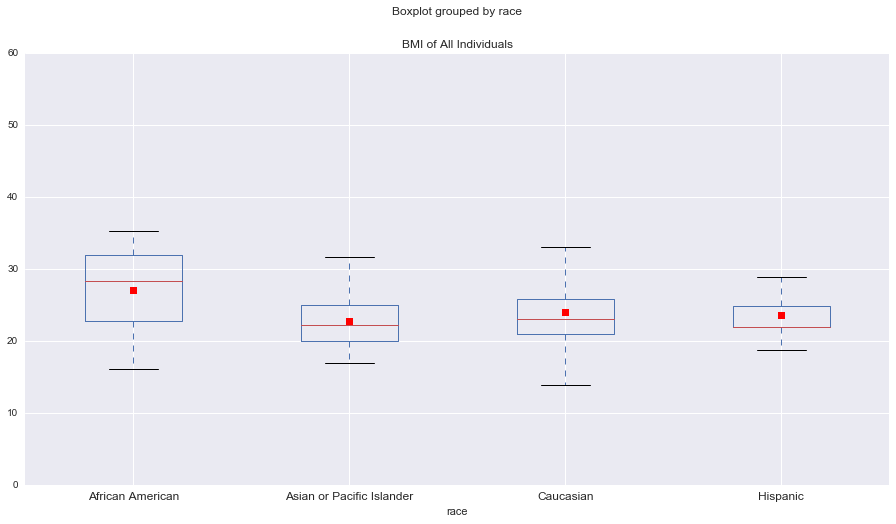

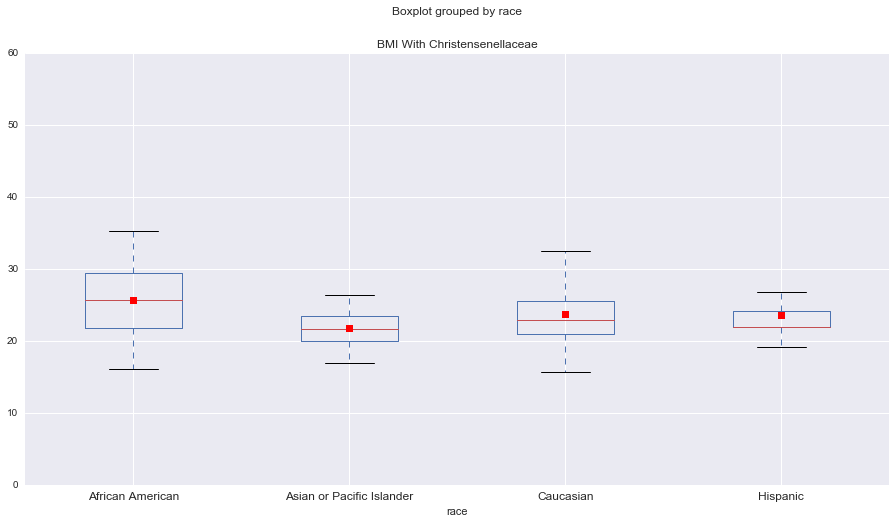

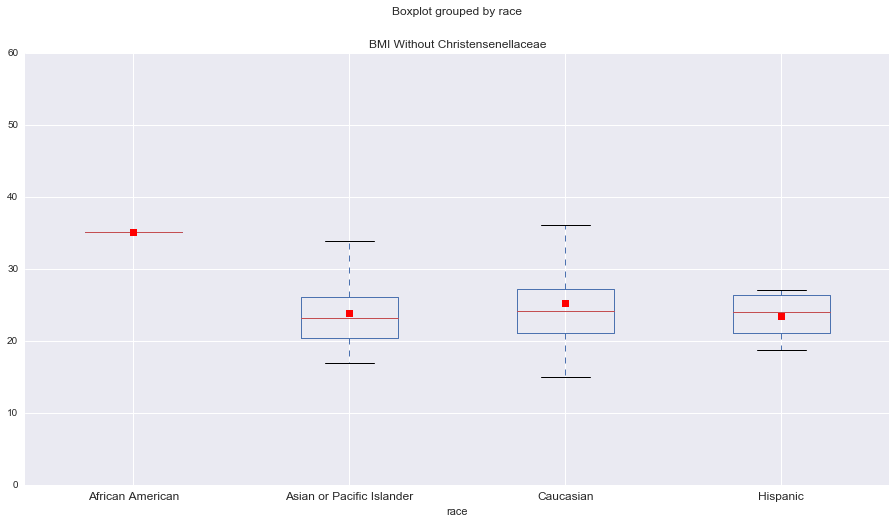

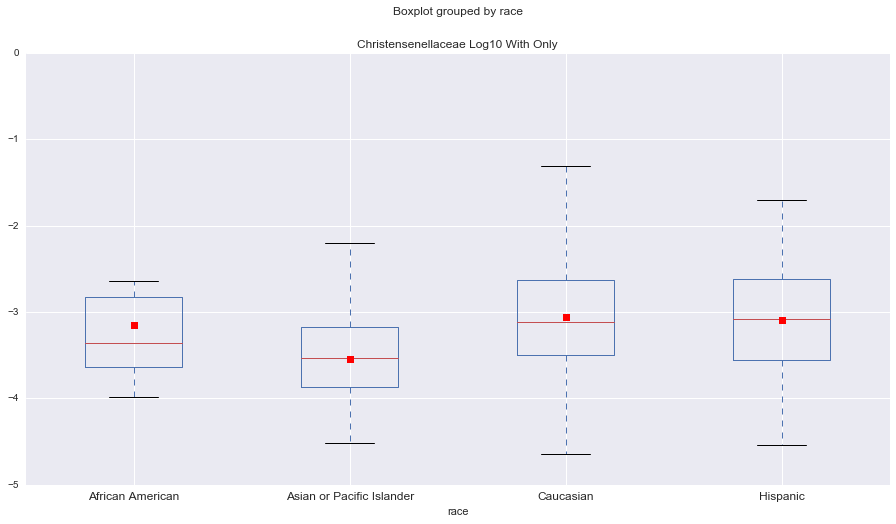

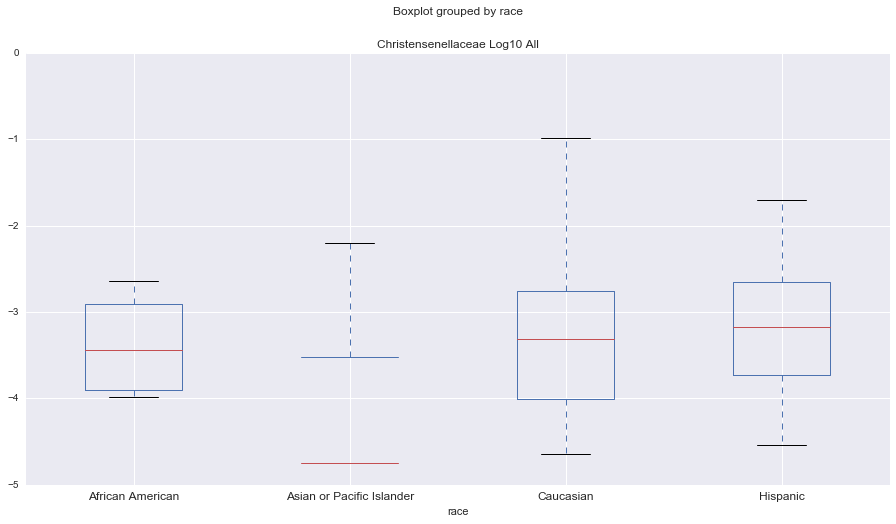

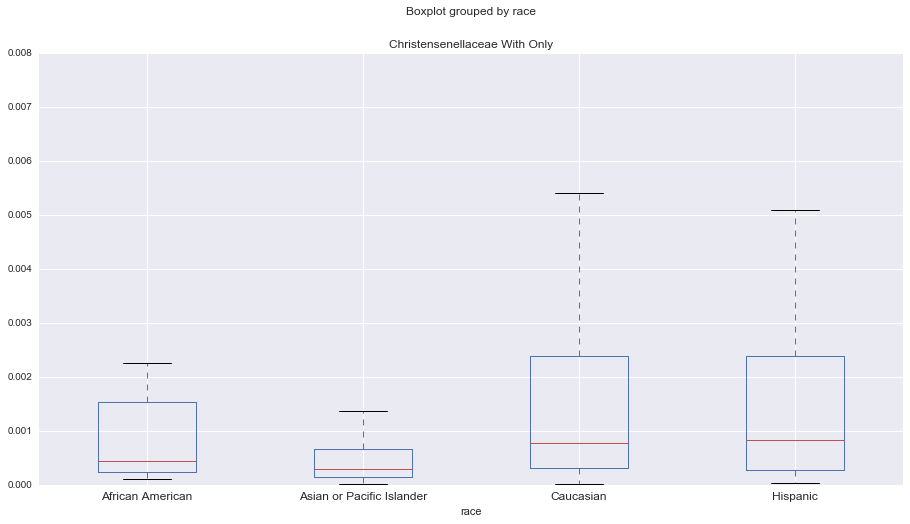

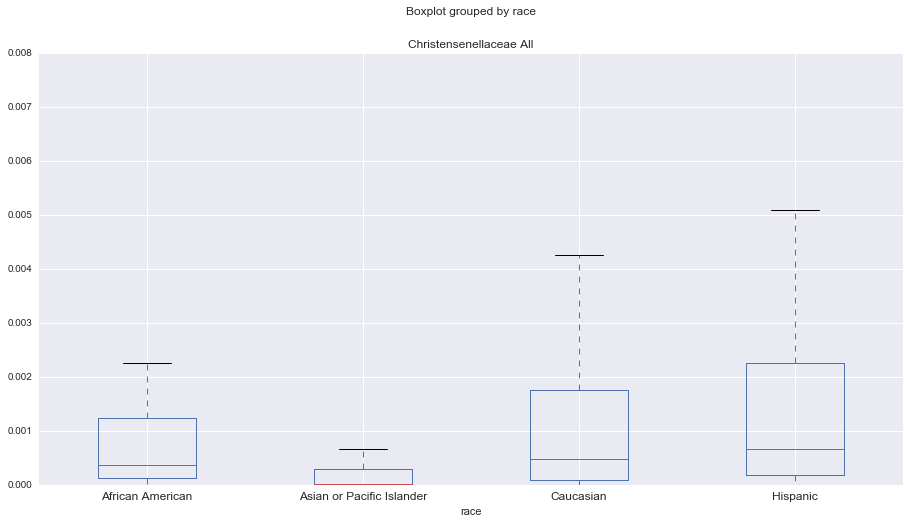

In [24]:
### BOXPLOTS OF BMIS FOR INDIVDIDUALS WITH AND WITHOUT CHRISTENSENELLACEAE USED IN MANUSCRIPT - MEANS ARE INCLUDED AS RED BOXES ###
os.system('mkdir christensenellaceae/')
print( "BOXPLOTS OF BMIS FOR INDIVDIDUALS WITH AND WITHOUT CHRISTENSENELLACEAE USED IN MANUSCRIPT - MEANS ARE INCLUDED AS RED BOXES")
ax1 = mapChrist.boxplot(column='bmi', by='race', figsize=[15,8], showmeans=True)
plt.title('BMI of All Individuals')
ax1.set_ylim(0,60)
plt.savefig("christensenellaceae/bmi_all.pdf")

ax2 = mapChristR.boxplot(column='bmi', by='race', figsize=[15,8], showmeans=True)
plt.title('BMI With Christensenellaceae')
ax2.set_ylim(0,60)
plt.savefig("christensenellaceae/bmi_with.pdf")

ax3 = mapChristRWO.boxplot(column='bmi', by='race', figsize=[15,8], showmeans=True)
plt.title('BMI Without Christensenellaceae')
ax3.set_ylim(0,60)
plt.savefig("christensenellaceae/bmi_without.pdf")

ax4 = mapChristR.boxplot(column='ChristLog', by='race', figsize=[15,8], showmeans=True)
plt.title('Christensenellaceae Log10 With Only')
plt.savefig("christensenellaceae/log_abund.pdf")
ax4.set_ylim(-5,0)

ax5 = mapChrist.boxplot(column='ChristLog', by='race', figsize=[15,8], showmeans=True)
plt.title('Christensenellaceae Log10 All')
plt.savefig("christensenellaceae/log_abund_all.pdf")
ax5.set_ylim(-5,0)

ax6 = mapChristR.boxplot(column='Christ', by='race', figsize=[15,8])#, showmeans=True)
plt.title('Christensenellaceae With Only')
ax6.set_ylim(0,0.008)
plt.savefig("christensenellaceae/abund.pdf")

ax7 = mapChrist.boxplot(column='Christ', by='race', figsize=[15,8])#, showmeans=True)
plt.title('Christensenellaceae All')
ax7.set_ylim(0,0.008)
plt.savefig("christensenellaceae/abund_all.pdf")


<h4 style="text-align:center; color:orange;"> - REGRESSION OF BMI AGAINST CHRISTENSENELLACEAE ABUNDANCE -

 </h4>

Slope: -0.0118213550181
R^2  : 0.00572898027875
p-val: 0.012925795708


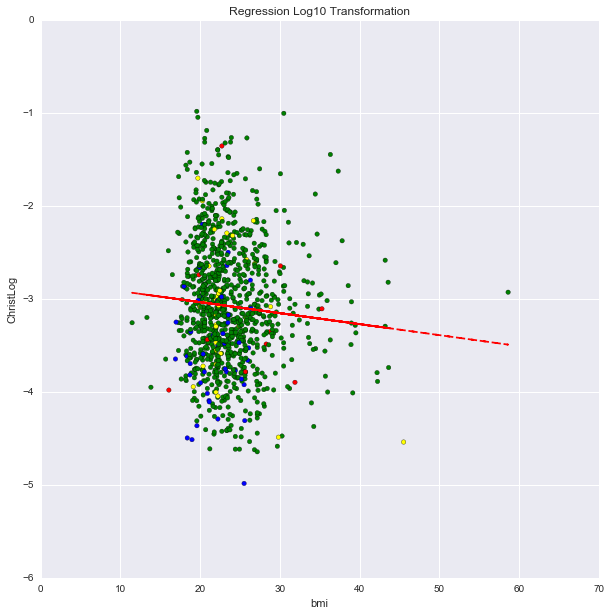

In [25]:
# Set Colors
colors = {'African American':'red', 'Asian or Pacific Islander':'blue', 'Caucasian':'green', 'Hispanic':'yellow'}

# Plot Log10
mapChristR.plot(kind='scatter', x='bmi', y='ChristLog', c=mapChristR['race'].apply(lambda x: colors[x]), figsize=[10,10])
plt.title("Regression Log10 Transformation")

#mapChristR["ChristLog"] = mapChristR["ChristLog"].replace(to_replace='-inf', value=-10)

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(mapChristR["bmi"],mapChristR["ChristLog"])
line = slope*mapChristR["bmi"]+intercept
plt.plot(mapChristR["bmi"],line, 'r--')
print ("Slope: " + str(slope))
print ("R^2  : " + str(r_value*r_value))
print ("p-val: " + str(p_value))
plt.savefig("christensenellaceae/reg_Log10_only_chr.pdf")
plt.show()